In [1]:
from typing import final

import mediapipe as mp
import matplotlib.pyplot as plt
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks.python.components.containers import NormalizedLandmark
from rembg import remove
from PIL import Image
import numpy as np

## Parameters

In [2]:
mediapipe_model_path = '../hand_landmarker.task'
mediapipe_gesture_recognizer_model_path = '../gesture_recognizer.task'
RGB_image_directory = '../../resources/evaluation_dataset/RGB'
RGB_ground_truth_directory = '../../resources/evaluation_dataset/RGB_annotation'
IR_image_directory = '../../resources/evaluation_dataset/IR'
IR_ground_truth_directory = '../../resources/evaluation_dataset/IR_annotations'
bad_score_penalty = 1
distance_threshold = 0.05
pck_distance_threshold = 0.05


## Create Models

In [3]:
base_options = python.BaseOptions(model_asset_path=mediapipe_gesture_recognizer_model_path)
options = vision.GestureRecognizerOptions(base_options=base_options,
                                          num_hands=2)

options.canned_gesture_classifier_options.score_threshold = 0
gesture_recognizer = vision.GestureRecognizer.create_from_options(options)

## Drawing Landmarks

In [4]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [5]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image_from_json(rgb_image, evaluation_result):
  hand_landmarks_list = evaluation_result['landmarks']
  # handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    # handedness = handedness_list[idx]
    height, width, _ = annotated_image.shape
    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=float(landmark['x']), y=float(landmark['y']), z=0.0) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
   
    x_coordinates = [landmark['x'] for landmark in hand_landmarks]
    y_coordinates = [landmark['y'] for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Assessing the Accuracy

In [6]:
def calculate_accuracy(ground_truth, prediction, threshold):
    if prediction is None:  # Missing landmark
        return 0.0
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return max(0, 1 - distance / threshold) * 100

In [7]:
from itertools import permutations

def calculate_hand_accuracies(ground_truth_hands, predicted_hands, handedness_info, threshold):
    accuracies = {"Left": [], "Right": []}

    # If no hands detected, accuracy is 0% for both hands
    if len(predicted_hands) == 0:
        return {"Left": [0.0]*21, "Right": [0.0]*21}
    

    first_predicted_hand = predicted_hands[0]

    hand_accuracy_1 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_accuracy_2 = [
        calculate_accuracy(gt_landmark, pred_landmark, threshold)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_accuracy_1) > sum(hand_accuracy_2):
        accuracies["Left"] = hand_accuracy_1
        accuracies["Right"] = [0.0]*21
        return accuracies
    elif len(predicted_hands) == 1:
        accuracies["Right"] = hand_accuracy_2
        accuracies["Left"] = [0.0]*21
        return accuracies
    else:
        second_predicted_hand = predicted_hands[1]
        hand_accuracy_3 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_accuracy_4 = [
            calculate_accuracy(gt_landmark, pred_landmark, threshold)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_accuracy_1) + sum(hand_accuracy_4) > sum(hand_accuracy_2) + sum(hand_accuracy_3):
            accuracies["Left"] = hand_accuracy_1
            accuracies["Right"] = hand_accuracy_4
        else:
            accuracies["Right"] = hand_accuracy_2
            accuracies["Left"] = hand_accuracy_3

    return accuracies

In [8]:
def assess_accuracy(image_path, ground_truth_hands, threshold=distance_threshold):
    """
    Assess accuracy of predictions for a given image.
    """
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) == 0:
        # print(f"No hands detected for {image_path}")
        return {"Left": [0.0]*21, "Right": [0.0]*21}

    return calculate_hand_accuracies(
        ground_truth_hands,
        results.hand_landmarks,
        results.handedness,
        threshold
    )

## Calculating Distance and Average Sum of Distance for the Dataset

In [9]:
def calculate_euclidean_distance(ground_truth, prediction):
    distance = np.sqrt((float(ground_truth["x"]) - prediction.x) ** 2 + 
                       (float(ground_truth["y"]) - prediction.y) ** 2)
    return distance

In [10]:
def calculate_sum_of_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return sum([bad_score_penalty*21]) + sum([bad_score_penalty*21])
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = sum(hand_distances_1)
        distances["Right"] = sum([bad_score_penalty*21])
    elif len(predicted_hands) == 1:
        distances["Right"] = sum(hand_distances_2)
        distances["Left"] = sum([bad_score_penalty*21])
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = sum(hand_distances_1)
            distances["Right"] = sum(hand_distances_4)
        else:
            distances["Right"] = sum(hand_distances_2)
            distances["Left"] = sum(hand_distances_3)
            
    

    return distances["Left"] + distances["Right"]

In [11]:
def calculate_sum_of_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distance = calculate_sum_of_distances(ground_truth_hands, results.hand_landmarks)
    
    return distance

In [12]:
def calculate_distances(ground_truth_hands, predicted_hands):
    distances = {"Left": [], "Right": []}
    if len(predicted_hands) == 0:
        return {"Left": [bad_score_penalty] * 21, "Right": [bad_score_penalty] * 21 }
    
    if len(predicted_hands) == 1:
        print("Only one hand detected")

    first_predicted_hand = predicted_hands[0]

    hand_distances_1 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[0], first_predicted_hand)
    ]

    hand_distances_2 = [
        calculate_euclidean_distance(gt_landmark, pred_landmark)
        for gt_landmark, pred_landmark in zip(ground_truth_hands[1], first_predicted_hand)
    ]

    if len(predicted_hands) == 1 and sum(hand_distances_1) < sum(hand_distances_2):
        distances["Left"] = hand_distances_1
        distances["Right"] = [bad_score_penalty] * 21
    elif len(predicted_hands) == 1:
        distances["Right"] = hand_distances_2
        distances["Left"] = [bad_score_penalty] * 21
    else:
        second_predicted_hand = predicted_hands[1]
        hand_distances_3 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[0], second_predicted_hand)
        ]

        hand_distances_4 = [
            calculate_euclidean_distance(gt_landmark, pred_landmark)
            for gt_landmark, pred_landmark in zip(ground_truth_hands[1], second_predicted_hand)
        ]

        if sum(hand_distances_1) + sum(hand_distances_4) < sum(hand_distances_2) + sum(hand_distances_3):
            distances["Left"] = hand_distances_1
            distances["Right"] = hand_distances_4
        else:
            distances["Right"] = hand_distances_2
            distances["Left"] = hand_distances_3
            
    return distances

In [13]:
def calculate_avg_distance_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return sum(distances["Left"] + distances["Right"]) / len(distances["Left"] + distances["Right"])

In [14]:
def calculate_distances_for_image(image_path, ground_truth_hands):
    image = mp.Image.create_from_file(image_path)
    results = gesture_recognizer.recognize(image)
    distances = calculate_distances(ground_truth_hands, results.hand_landmarks)
    
    return distances["Left"] + distances["Right"]

## Creating Thresholds/Bounds


In [15]:
def calculate_final_accuracy(scores):
    all_scores = scores["Left"] + scores["Right"]
    return sum(all_scores) / len(all_scores) if all_scores else 0.0

In [16]:
import os
import json

def calculate_bound_accuracy(image_directory, ground_truth_directory, threshold):
    total_bound = {"Left": [], "Right":[]}
    for file_name in os.listdir(ground_truth_directory):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(ground_truth_directory, file_name)
            
            with open(json_file_path, 'r') as f:
                ground_truth_data = json.load(f)
                
            for entry in ground_truth_data:
                image_name = entry["image"]
                ground_truth_landmarks = entry["landmarks"]
                image_path = os.path.join(image_directory, image_name)
    
                # Assess accuracy for RGB images (upper bound)
                score = assess_accuracy(image_path, ground_truth_landmarks, threshold)
                
                for hand in ["Left", "Right"]:
                    total_bound[hand].extend(score[hand])
    return calculate_final_accuracy(total_bound)
    

In [17]:
upper_bound_accuracy = calculate_bound_accuracy(RGB_image_directory, RGB_ground_truth_directory, 0.05)
lower_bound_accuracy = calculate_bound_accuracy(IR_image_directory ,IR_ground_truth_directory, 0.05)

In [18]:
print(f"Upper Bound Accuracy (RGB): {upper_bound_accuracy:.2f}%")
print(f"Lower Bound Accuracy (Infrared): {lower_bound_accuracy:.2f}%")

Upper Bound Accuracy (RGB): 84.26%
Lower Bound Accuracy (Infrared): 42.82%


## Visualizing Thresholds

In [19]:
def visualize_threshold_roi(image_path, ground_truth_landmarks, threshold, output_path):
    """
    Visualizes regions of interest (ROIs) based on the threshold for accuracy.

    Parameters:
        image_path (str): Path to the image file.
        ground_truth_landmarks (list of dict): Ground truth landmarks with 'x' and 'y' coordinates.
        threshold (float): Distance threshold for accuracy calculation.
        output_path (str): Path to save the output visualization image.
    """
    # Load the image
    image = cv2.imread(image_path)
    overlay = image.copy()

    height, width, _ = image.shape

    # Draw circles around the ground truth landmarks
    for hand in ground_truth_landmarks:
        for landmark in hand:
            center = (int(float(landmark['x']) * width), int(float(landmark['y']) * height))
            radius = int(threshold*width)  # Scale threshold to image dimensions
            color = (0, 255, 0)  # Green color for the circle
            alpha = 0.25  # Transparency factor
    
            # Draw the circle on the overlay
            cv2.circle(overlay, center, radius, color, -1)

    # Blend the overlay with the original image
    cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)

    # Save the output image
    cv2.imwrite(output_path, image)

## Transforming Images

In [20]:
import sys
sys.path.append('../')
sys.path.append('../colorization/zhang')

In [21]:
from src.colorization.Zhang import create_colorized_pictures
def colorize_zhang_eccv16(image_path, image_name):
    print(f"Colorizing {image_name} using Zhang ECCV16 model...")
    create_colorized_pictures(model='eccv16', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/eccv16/{image_name}_eccv16.png'

In [22]:
def colorize_zhang_siggraph17(image_path, image_name):
    print(f"Colorizing {image_name} using Zhang SIGGRAPH17 model...")
    create_colorized_pictures(model='siggraph17', img_path=image_path, save_prefix=image_name)  
    return f'../../resources/stylized-pictures/siggraph17/{image_name}_siggraph17.png'
    

In [23]:
def clahe(image, clipLimit=2.0, tileGridSize=(8, 8), save_path=None, save_as_rgb=True):
    """
    Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - clipLimit: Threshold for contrast limiting.
    - tileGridSize: Size of the grid for histogram equalization.
    - save_path: Path to save the output image.
    - save_as_rgb: Save the CLAHE-applied image in RGB format if True.
    
    Returns:
    - Processed image in grayscale or RGB format.
    """
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:  # If RGB/BGR
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    clahe_image = clahe.apply(gray)

    # Convert back to RGB if required
    if save_as_rgb:
        clahe_image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    else:
        clahe_image_rgb = clahe_image

    # Save the image if a save_path is provided
    if save_path:
        cv2.imwrite(save_path, clahe_image_rgb if save_as_rgb else clahe_image)
        print(f"CLAHE-applied image saved at {save_path}")

    return clahe_image_rgb if save_as_rgb else clahe_image


In [24]:
def reduce_brightness(image_path, save_path, reduction_factor=0.5):
    """
    Reads an image, reduces its brightness, and saves the result.
    
    Parameters:
    - image_path: Path to the input image.
    - save_path: Path to save the output image.
    - reduction_factor: Factor by which to reduce brightness (0.0 to 1.0, where 1.0 is no change).
    
    Returns:
    - The brightness-reduced image as a NumPy array.
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Convert to float to avoid clipping during multiplication
    image = image.astype(np.float32)

    # Reduce brightness
    brightness_reduced = np.clip(image * reduction_factor, 0, 255).astype(np.uint8)

    # Save the result
    cv2.imwrite(save_path, brightness_reduced)
    print(f"Brightness-reduced image saved at {save_path}")

    return brightness_reduced


In [25]:
def remove_background(image_path, save_path):
    # Processing the image 
    input = Image.open(image_path)
    
    # Removing the background from the given Image 
    output = remove(input)
    
    # Saving the image in the given path
    output.save(save_path)

In [26]:
def gaussian_smoothing(image, kernel_size=(5, 5), sigma=0):
    """
    Applies Gaussian smoothing to an image.
    
    Parameters:
    - image: Input image (grayscale or BGR/RGB).
    - kernel_size: Size of the Gaussian kernel (height, width).
    - sigma: Standard deviation of the Gaussian distribution.
    
    Returns:
    - Smoothed image.
    """
    image = cv2.imread(f"../../resources/stylized-pictures/no_background/{image_name}_background_removed.png")
    # Apply median blur
    median_blur = cv2.medianBlur(image, 5)
    #smoothed = cv2.GaussianBlur(image, kernel_size, sigma)
    # Save the smoothed image
    cv2.imwrite(f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png", median_blur)
    return f"../../resources/stylized-pictures/no_background/smoothed/{image_name}_smoothed.png"
    

In [27]:
import cv2
import numpy as np

def remove_temperature_boxes(image_path, image_name):
    # Load the image using OpenCV
    image_cv = cv2.imread(image_path)

    # Convert to HSV to target specific colors (red and green boxes)
    hsv_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)

    # Define color ranges for red and green (in HSV space)
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])

    # Create masks for red and green
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    mask_red = mask_red1 | mask_red2

    # Combine masks for both colors
    mask_combined = mask_red | mask_green

    # Dilate the mask slightly to cover edges of the red and green regions
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask_combined, kernel, iterations=1)

    # Inpaint to remove red and green regions
    image_no_boxes = cv2.inpaint(image_cv, dilated_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    # Apply Gaussian blur to smooth the entire image
    smoothed_image = cv2.GaussianBlur(image_no_boxes, (5, 5), 0)

    # Save the final image
    smoothed_output_path = f"../../resources/stylized-pictures/no_boxes/{image_name}_no_boxes.png"
    cv2.imwrite(smoothed_output_path, smoothed_image)

    return smoothed_output_path



In [28]:
def mask_temperature_scale(image_path, output_path):
    """
    Masks the temperature scale on the left side of the image
    by replacing it with the average background color.
    """
    # Load the image
    image = cv2.imread(image_path)

    # Define the regions to mask
    scale_width = 210  # Width of the scale region on the left
    temp_box_width = 260  # Width of the temperature box in the top-right
    temp_box_height = 90  # Height of the temperature box in the top-right

    # Mask the left temperature scale
    scale_region = image[:, :scale_width]
    avg_color_scale = np.mean(image[:, scale_width:], axis=(0, 1), dtype=int)
    image[:, :scale_width] = avg_color_scale

    # Mask the temperature box in the upper-right corner
    temp_box_region = image[:temp_box_height, -temp_box_width:]
    avg_color_temp_box = np.mean(image[temp_box_height:, :-temp_box_width], axis=(0, 1), dtype=int)
    image[:temp_box_height, -temp_box_width:] = avg_color_temp_box

     # Save the masked image
    cv2.imwrite(output_path, image)

    return output_path

In [29]:
def detect_edges_sobelX(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)

def detect_edges_sobelY(image):
    """Detects edges in an image using the Sobel edge detection algorithm"""
    return cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

In [30]:
def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Apply Gaussian blur to reduce noise and smoothen edges 
    blurred = cv2.GaussianBlur(src=frame, ksize=(3, 5), sigmaX=0.5) 
      
    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 70, 135) 
      
    return blurred, edges

In [31]:
# Check whether recognized hands are left or right
def is_right_hand(landmarks):
    counter = 0
    
    for landmark in landmarks:
        if landmark.x > 0.5:
            counter += 1
            
    return counter > 10

# PCK Metric


In [32]:
def calculate_pck(ground_truth_hand, predicted_hand, threshold):
    """
    Calculates the Percentage of Correct Keypoints (PCK) metric for a given threshold.
    """
    total_landmarks = 21
    correct_landmarks = 0
    
    for gt_landmark, pred_landmark in zip(ground_truth_hand, predicted_hand):
        distance = np.sqrt((gt_landmark['x'] - pred_landmark.x) ** 2 +
                            (gt_landmark['y'] - pred_landmark.y) ** 2)
        if distance <= threshold:
            correct_landmarks += 1
            
    return correct_landmarks / total_landmarks
    
    
    

In [33]:
# def calculate_best_pck(ground_truth_hands, predicted_hands, threshold):
#     pck = {"Left": 0.0, "Right": 0.0}
# 
#     # If no hands detected, accuracy is 0% for both hands
#     if len(predicted_hands) == 0:
#         return {"Left": 0.0, "Right": 0.0}
#     
# 
#     first_predicted_hand = predicted_hands[0]
# 
#     hand_pck_1 = calculate_pck(ground_truth_hands[0], first_predicted_hand, threshold)
#     hand_pck_2 = calculate_pck(ground_truth_hands[1], first_predicted_hand, threshold)
#     
#     if len(predicted_hands) == 1 and hand_pck_1 > hand_pck_2:
#         pck["Left"] = hand_pck_1
#         pck["Right"] = 0.0
#         return pck
#     elif len(predicted_hands) == 1:
#         pck["Right"] = hand_pck_2
#         pck["Left"] = 0.0
#         return pck
#     else:
#         second_predicted_hand = predicted_hands[1]
#         hand_pck_3 = calculate_pck(ground_truth_hands[0], second_predicted_hand, threshold)
#         hand_pck_4 = calculate_pck(ground_truth_hands[1], second_predicted_hand, threshold)
#         
#         if hand_pck_1 + hand_pck_4 > hand_pck_2 + hand_pck_3:
#             pck["Left"] = hand_pck_1
#             pck["Right"] = hand_pck_4
#         else:
#             pck["Right"] = hand_pck_2
#             pck["Left"] = hand_pck_3
# 
#     return pck

In [34]:
def assess_pck_accuracy(image_path, ground_truth_hands, threshold):
    """
    Assess accuracy of predictions for a given image.
    """
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) == 0:
        # print(f"No hands detected for {image_path}")
        return {"Left": 0.0, "Right": 0.0}

    return calculate_best_pck_adaptive(
        ground_truth_hands,
        results.hand_landmarks,
        threshold
    )

In [35]:
def calculate_adaptive_threshold(ground_truth_hand, threshold):
    wrist_point = ground_truth_hand[0]
    top_of_middle_finger = ground_truth_hand[12]
    
    distance = np.sqrt((wrist_point['x'] - top_of_middle_finger['x']) ** 2 +
                          (wrist_point['y'] - top_of_middle_finger['y']) ** 2)
    return distance * threshold

In [36]:
def calculate_best_pck_adaptive(ground_truth_hands, predicted_hands, threshold):
    pck = {"Left": 0.0, "Right": 0.0}

    # If no hands detected, accuracy is 0% for both hands
    if len(predicted_hands) == 0:
        return {"Left": 0.0, "Right": 0.0}
    

    first_predicted_hand = predicted_hands[0]
    threshold_for_left_hand = calculate_adaptive_threshold(ground_truth_hands[0], threshold)
    threshold_for_right_hand = calculate_adaptive_threshold(ground_truth_hands[1], threshold)

    hand_pck_1 = calculate_pck(ground_truth_hands[0], first_predicted_hand, threshold_for_left_hand)
    hand_pck_2 = calculate_pck(ground_truth_hands[1], first_predicted_hand, threshold_for_right_hand)
    
    if len(predicted_hands) == 1 and hand_pck_1 > hand_pck_2:
        pck["Left"] = hand_pck_1
        pck["Right"] = 0.0
        return pck
    elif len(predicted_hands) == 1:
        pck["Right"] = hand_pck_2
        pck["Left"] = 0.0
        return pck
    else:
        second_predicted_hand = predicted_hands[1]
        hand_pck_3 = calculate_pck(ground_truth_hands[0], second_predicted_hand, threshold_for_left_hand)
        hand_pck_4 = calculate_pck(ground_truth_hands[1], second_predicted_hand, threshold_for_right_hand)
        
        if hand_pck_1 + hand_pck_4 > hand_pck_2 + hand_pck_3:
            pck["Left"] = hand_pck_1
            pck["Right"] = hand_pck_4
        else:
            pck["Right"] = hand_pck_2
            pck["Left"] = hand_pck_3
    return pck

In [37]:
def assess_pck(image_path, ground_truth_hands, threshold):
    """
    Assess accuracy of predictions for a given image.
    """
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) == 0:
        print(f"No hands detected for {image_path}")
        return {"Left": 0.0, "Right": 0.0}
    
    
    return calculate_best_pck_adaptive(ground_truth_hands, results.hand_landmarks, threshold)

In [38]:
import os
import json

def calculate_bound_pck(image_directory, ground_truth_directory, threshold):
    total_bound = {"Left": [], "Right":[]}
    for file_name in os.listdir(ground_truth_directory):
        if file_name.endswith('.json'):
            json_file_path = os.path.join(ground_truth_directory, file_name)
            
            with open(json_file_path, 'r') as f:
                ground_truth_data = json.load(f)
                
            for entry in ground_truth_data:
                image_name = entry["image"]
                ground_truth_landmarks = entry["landmarks"]
                image_path = os.path.join(image_directory, image_name)
    
                # Assess accuracy for RGB images (upper bound)
                pck = assess_pck(image_path, ground_truth_landmarks, threshold)
                # score = assess_accuracy(image_path, ground_truth_landmarks)
                
                for hand in ["Left", "Right"]:
                    total_bound[hand].append(pck[hand])
    return calculate_final_accuracy(total_bound)
    

In [39]:
pck_upper_bound = calculate_bound_pck(RGB_image_directory, RGB_ground_truth_directory, 0.05)
pck_lower_bound = calculate_bound_pck(IR_image_directory ,IR_ground_truth_directory, 0.05)

No hands detected for ../../resources/evaluation_dataset/IR\3_IMG20241127100408.jpg
No hands detected for ../../resources/evaluation_dataset/IR\5_IMG20241127100507.jpg
No hands detected for ../../resources/evaluation_dataset/IR\6_IMG20241127100515.jpg
No hands detected for ../../resources/evaluation_dataset/IR\10_IMG20241127100740.jpg
No hands detected for ../../resources/evaluation_dataset/IR\11_IMG20241127100906.jpg
No hands detected for ../../resources/evaluation_dataset/IR\12_IMG20241127100913.jpg
No hands detected for ../../resources/evaluation_dataset/IR\13_IMG20241127101012.jpg
No hands detected for ../../resources/evaluation_dataset/IR\14_IMG20241127101019.jpg
No hands detected for ../../resources/evaluation_dataset/IR\29_IMG20241127102051.jpg
No hands detected for ../../resources/evaluation_dataset/IR\38_IMG20241127102643.jpg
No hands detected for ../../resources/evaluation_dataset/IR\39_IMG20241127102649.jpg
No hands detected for ../../resources/evaluation_dataset/IR\40_IMG20

In [40]:
print(f"Upper Bound PCK (RGB): {pck_upper_bound:.2f}%")
print(f"Lower Bound PCK (Infrared): {pck_lower_bound:.2f}%")

Upper Bound PCK (RGB): 0.84%
Lower Bound PCK (Infrared): 0.45%


## Load Data

In [41]:
results = []

## Processing Images

In [42]:
from rembg import remove 
from PIL import Image

In [43]:
def remove_cross(image_path, image_name):
    """
    Removes the white cross from the center of an image by creating a mask and applying inpainting.
    """
    # Load the image in color
    image = cv2.imread(image_path)
    
    # Get image dimensions
    h, w = image.shape[:2]
    center_x, center_y = w // 2, h // 2
    
    # Define cross size (adjust as needed)
    cross_size = 50  # Length of the cross arms
    thickness = 10   # Thickness of the lines

    # Create a mask for the cross
    mask = np.zeros((h, w), dtype=np.uint8)
    # Draw horizontal and vertical lines for the cross
    cv2.line(mask, (center_x - cross_size, center_y), (center_x + cross_size, center_y), 255, thickness)
    cv2.line(mask, (center_x, center_y - cross_size), (center_x, center_y + cross_size), 255, thickness)

    # Apply inpainting to remove the cross
    result = cv2.inpaint(image, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
    
    path = f"../../resources/stylized-pictures/no_cross/{image_name}_no_cross.png"
    cv2.imwrite(path, result)
    
    return path


In [44]:
def execute_transformation_pipeline(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(no_boxes_image_path))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [45]:
def execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    # no_cross_path = remove_cross(no_boxes_image_path, image_name)
    
    image = cv2.imread(no_boxes_image_path, cv2.IMREAD_GRAYSCALE)
    
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg", enhanced_image)
    
    # Step 4: Sharpen edges to highlight fingers
    # kernel = np.array([[-1, -1, -1],
    #                    [-1,  9, -1],
    #                    [-1, -1, -1]])
    # sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    # 
    # # Change the image to RGB format
    sharpened_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [46]:
def two_hands_detected(image_path):
    image = mp.Image.create_from_file(image_path)
    
    results = gesture_recognizer.recognize(image)
    
    if not results.hand_landmarks or len(results.hand_landmarks) < 2:
        return False
    return True

In [47]:
def create_landmarks_from_results(results):
    landmarks = results.hand_landmarks
    gestures = results.gestures
    final_landmarks = {}
    
    for i, hand_landmarks in enumerate(landmarks):
        hand_gestures = gestures[i]
        handedness = 'Right' if is_right_hand(hand_landmarks) else 'Left'
        
        final_landmarks[handedness] = {"landmarks": hand_landmarks, "gestures": hand_gestures[0].category_name, "score": hand_gestures[0].score}

    
    return final_landmarks
    

In [48]:
def annotate_landmarks(image_path, results, output_path):
    try:
        image = cv2.imread(image_path)
        annotated_image = np.copy(image)
        
        for hand in results:
            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand
            ])
            solutions.drawing_utils.draw_landmarks(
                annotated_image,
                hand_landmarks_proto,
                solutions.hands.HAND_CONNECTIONS,
                solutions.drawing_styles.get_default_hand_landmarks_style(),
                solutions.drawing_styles.get_default_hand_connections_style()
            )
        
        cv2.imwrite(output_path, annotated_image)
    except Exception as e:
        print(f"COULD NOT ANNOTATE LANDMARKS FOR {image_path.upper()}: {str(e).upper()}")


In [49]:
def rotate_landmarks_90_counterclockwise(landmarks):
    rotated_landmarks = []
    for group in landmarks:
        rotated_group = []
        for point in group:
            x, y = point['x'], point['y']
            rotated_group.append({'x': y, 'y': 1 - x})
        rotated_landmarks.append(rotated_group)
    return rotated_landmarks

In [60]:
total_transformed_siggraph17 = {"Left": [], "Right": []}
total_transformed_eccv16 = {"Left": [], "Right": []}


In [61]:
total_pck_higher_threshold = {"Left": [], "Right": []}
total_pck_lower_threshold = {"Left": [], "Right": []}
total_pck_adaptive = {"Left": [], "Right": []}

In [62]:
total_distances_siggaph17 = []
total_distances_eccv16 = []

In [63]:
hand_landmarker_first = {"Left": [], "Right": []}
hand_landmarker_second = {"Left": [], "Right": []}

gesture_recognizer_first = {"Left": [], "Right": []}
gesture_recognizer_second = {"Left": [], "Right": []}

In [64]:
def advanced_enhancement(image_path, image_name):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    no_cross_path = remove_cross(no_boxes_image_path, image_name)
    # Load the image in grayscale
    image = cv2.imread(no_cross_path, cv2.IMREAD_GRAYSCALE)
    # Apply histogram equalization
    equalized = cv2.equalizeHist(image)
    # Invert the colors
    inverted = cv2.bitwise_not(equalized)
    # Apply GaussianBlur to reduce noise and enhance features
    blurred = cv2.GaussianBlur(inverted, (5, 5), 0)
    # Combine equalization and inversion for better contrast
    combined = cv2.addWeighted(equalized, 0.7, blurred, 0.3, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(combined)
    
    # Change the image to RGB format
    # sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)
    # Save the enhanced image
    enhanced_path = f"../../resources/stylized-pictures/enhanced/{image_name}_enhanced.png"
    cv2.imwrite(enhanced_path, cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB))

    return enhanced_path

In [65]:
def fourth_pipeline(image_path, image_name):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    return no_boxes_image_path

In [66]:
class Category:
    def __init__(self, category_name):
        self.category_name = category_name

In [67]:
class Results:
    def __init__(self, hand_landmarks, handedness):
        self.hand_landmarks = hand_landmarks
        self.handedness = handedness

In [68]:
def merge_landmarks(pipelines, handedness):
    def is_fingers_correct_order(landmarks):
        # Extract x-coordinates for all landmarks
        x_coords = [landmarks[i].x for i in range(len(landmarks))]
        
        if handedness == "Right":
            # Right hand: all pinky points (6 to 20) should be to the left of the thumb (2, 3, 4)
            return all(x_coords[pinky] < x_coords[2] for pinky in range(10, 21))
        else:  # Left hand
            # Left hand: all pinky points (6 to 20) should be to the right of the thumb (2, 3, 4)
            return all(x_coords[pinky] > x_coords[2] for pinky in range(10, 21))

    def merge_logic(points, index):
        if index < 6:  # For the first 6 landmarks
            if handedness == "Left":
                return min(points, key=lambda p: p.x)  # Leftmost for left hand
            else:
                return max(points, key=lambda p: p.x)  # Rightmost for right hand
        else:  # For the remaining landmarks
            return min(points, key=lambda p: p.y)  # Lowest y

    correct_pipelines = [pipeline for pipeline in pipelines if is_fingers_correct_order(pipeline['landmarks'])]

    # If at least one correct pipeline is found
    if correct_pipelines:
        merged_landmarks = []
        num_landmarks = len(correct_pipelines[0]['landmarks'])

        for i in range(num_landmarks):
            # Extract corresponding landmarks from correct pipelines
            points = [pipeline['landmarks'][i] for pipeline in correct_pipelines]
            # Apply merging logic
            merged_landmarks.append(merge_logic(points, i))

        return merged_landmarks

    # No correct pipeline found, fall back to merging all pipelines
    merged_landmarks = []
    num_landmarks = len(pipelines[0]['landmarks'])

    for i in range(num_landmarks):
        points = [pipeline['landmarks'][i] for pipeline in pipelines]
        merged_landmarks.append(merge_logic(points, i))

    return merged_landmarks


In [72]:
import cv2
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            first_pipeline_pck = assess_pck_accuracy(first_pipeline_image_path, ground_truth_landmarks, 0.05)
            print(f"Results for original pipeline (PCK) - Left: {first_pipeline_pck['Left']:.2f}%, Right: {first_pipeline_pck['Right']:.2f}%")
            
            results = gesture_recognizer.recognize(mp.Image.create_from_file(first_pipeline_image_path))
            annotated = draw_landmarks_on_image(cv2.imread(first_pipeline_image_path), results)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/first/{image_name}.png", annotated)
            
            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            second_pipeline_score = assess_accuracy(second_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for second pipeline - Left: {np.mean(second_pipeline_score['Left']):.2f}%, Right: {np.mean(second_pipeline_score['Right']):.2f}%")
            
            second_pipeline_pck = assess_pck_accuracy(second_pipeline_image_path, ground_truth_landmarks, 0.05)
            print(f"Results for second pipeline (PCK) - Left: {second_pipeline_pck['Left']:.2f}%, Right: {second_pipeline_pck['Right']:.2f}%")
            
            results = gesture_recognizer.recognize(mp.Image.create_from_file(second_pipeline_image_path))
            annotated = draw_landmarks_on_image(cv2.imread(second_pipeline_image_path), results)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/second/{image_name}.png", annotated)
            
            # third_pipeline_image_path = advanced_enhancement(image_path, image_name)
            # third_pipeline_score = assess_accuracy(third_pipeline_image_path, ground_truth_landmarks)
            # print(f"Results for third pipeline - Left: {np.mean(third_pipeline_score['Left']):.2f}%, Right: {np.mean(third_pipeline_score['Right']):.2f}%")
            # 
            # results = gesture_recognizer.recognize(mp.Image.create_from_file(third_pipeline_image_path))
            # annotated = draw_landmarks_on_image(cv2.imread(third_pipeline_image_path), results)
            # cv2.imwrite(f"../../resources/stylized-pictures/annotated/third/{image_name}.png", annotated)
            # 
            # 
            # fourth_pipeline_image_path = fourth_pipeline(image_path, image_name)
            # fourth_pipeline_score = assess_accuracy(fourth_pipeline_image_path, ground_truth_landmarks)
            # print(f"Results for fourth pipeline - Left: {np.mean(fourth_pipeline_score['Left']):.2f}%, Right: {np.mean(fourth_pipeline_score['Right']):.2f}%")
            # 
            # results = gesture_recognizer.recognize(mp.Image.create_from_file(fourth_pipeline_image_path))
            # annotated = draw_landmarks_on_image(cv2.imread(fourth_pipeline_image_path), results)
            # cv2.imwrite(f"../../resources/stylized-pictures/annotated/fourth/{image_name}.png", annotated)
            
            image = mp.Image.create_from_file(first_pipeline_image_path)
            recognizer_results_first_pipeline = gesture_recognizer.recognize(image)
            first_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_first_pipeline)
            annotated_first = draw_landmarks_on_image(cv2.imread(first_pipeline_image_path), recognizer_results_first_pipeline)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/first/{image_name}.png", annotated_first)
            
            image = mp.Image.create_from_file(second_pipeline_image_path)
            recognizer_results_second_pipeline = gesture_recognizer.recognize(image)
            second_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_second_pipeline)
            annotated_second = draw_landmarks_on_image(cv2.imread(second_pipeline_image_path), recognizer_results_second_pipeline)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/second/{image_name}.png", annotated_second)
            
            # image = mp.Image.create_from_file(third_pipeline_image_path)
            # recognizer_results_third_pipeline = gesture_recognizer.recognize(image)
            # third_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_third_pipeline)
            # 
            # image = mp.Image.create_from_file(fourth_pipeline_image_path)
            # recognizer_results_fourth_pipeline = gesture_recognizer.recognize(image)
            # fourth_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_fourth_pipeline)
            
            # Initialize landmarks_gestures_score dictionary
            landmarks_gestures_score = {"Left": [], "Right": []}
            
            # Check if landmarks exist for each pipeline and append them accordingly
            if "Left" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(first_pipeline_gesture_score_landmarks["Left"])
            if "Right" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(first_pipeline_gesture_score_landmarks["Right"])
            
            if "Left" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(second_pipeline_gesture_score_landmarks["Left"])
            if "Right" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(second_pipeline_gesture_score_landmarks["Right"])
            
            # if "Left" in third_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Left"].append(third_pipeline_gesture_score_landmarks["Left"])
            # if "Right" in third_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Right"].append(third_pipeline_gesture_score_landmarks["Right"])
            # 
            # if "Left" in fourth_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Left"].append(fourth_pipeline_gesture_score_landmarks["Left"])
            # if "Right" in fourth_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Right"].append(fourth_pipeline_gesture_score_landmarks["Right"])
                
            final_landmarks = []
            
            for hand in ["Left", "Right"]:
                all_available_landmarks = landmarks_gestures_score[hand]
                
                if not all_available_landmarks:
                    continue
            
                # Step 1: Filter only open palm gestures
                open_palm_landmarks = [l for l in all_available_landmarks if l['gestures'] == 'Open_Palm']
            
                # Step 2: Handle multiple open palms
                if len(open_palm_landmarks) > 1:
                    merged_landmarks = merge_landmarks(open_palm_landmarks, hand)
                    final_landmarks.append(merged_landmarks)
            
                # Step 3: Handle a single open palm
                elif len(open_palm_landmarks) == 1:
                    final_landmarks.append(open_palm_landmarks[0]['landmarks'])
            
                # Step 4: No open palm detected, use lowest score gesture
                else:
                    lowest_score_landmark = min(all_available_landmarks, key=lambda l: l['score'])
                    final_landmarks.append(lowest_score_landmark['landmarks'])

                        
            # final_landmark_accuracy = calculate_hand_accuracies(ground_truth_landmarks, final_landmarks, ["Left", "Right"], distance_threshold)
            # final_landmark_accuracy["Left"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Left"])) else final_landmark_accuracy["Left"]
            # final_landmark_accuracy["Right"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Right"])) else final_landmark_accuracy["Right"]
            # print(f"Results for final score - Left: {np.mean(final_landmark_accuracy['Left']):.2f}%, Right: {np.mean(final_landmark_accuracy['Right']):.2f}%")
            # 
            # final_landmark_pck_higher_threshold = calculate_best_pck(ground_truth_landmarks, final_landmarks, pck_distance_threshold)
            # print(f"Results for final score PCK (0.05) - Left: {final_landmark_pck_higher_threshold['Left']:.2f}%, Right: {final_landmark_pck_higher_threshold['Right']:.2f}%")
            # 
            # 
            # final_landmark_pck_smaller_threshold = calculate_best_pck(ground_truth_landmarks, final_landmarks, pck_distance_threshold_smaller)
            # print(f"Results for final score PCK (0.025) - Left: {final_landmark_pck_smaller_threshold['Left']:.2f}%, Right: {final_landmark_pck_smaller_threshold['Right']:.2f}%")
            # 
            final_landmark_pck_adaptive_threshold = calculate_best_pck_adaptive(ground_truth_landmarks, final_landmarks, 0.05)
            print(f"Results for final score PCK (adaptive) - Left: {final_landmark_pck_adaptive_threshold['Left']:.2f}%, Right: {final_landmark_pck_adaptive_threshold['Right']:.2f}%")
            
            print(final_landmarks)

            # Annotate with final landmarks
            annotated_image_path = f"../../resources/stylized-pictures/annotated/{image_name}.png"
            annotate_landmarks(image_path, final_landmarks, annotated_image_path)
            
            # Create a picture of the 3 pictures
            from PIL import Image

            # # Open the three images
            image1 = Image.open(f"../../resources/stylized-pictures/annotated/first/{image_name}.png")
            image2 = Image.open(f"../../resources/stylized-pictures/annotated/second/{image_name}.png")
            # image3 = Image.open(f"../../resources/stylized-pictures/annotated/third/{image_name}.png")
            # image4 = Image.open(f"../../resources/stylized-pictures/annotated/fourth/{image_name}.png")
            image5 = Image.open(f"../../resources/stylized-pictures/annotated/{image_name}.png")
            # 
            # # Ensure all images have the same height
            height = min(image1.height, image2.height, image5.height)
            image1 = image1.resize((image1.width, height))
            image2 = image2.resize((image2.width, height))
            # image3 = image3.resize((image3.width, height))
            # image4 = image4.resize((image4.width, height))
            image5 = image5.resize((image5.width, height))
            # 
            # # Calculate total width
            total_width = image1.width + image2.width  + image5.width
            # 
            # # Create a new blank image
            concatenated_image = Image.new("RGB", (total_width, height))
            # 
            # # Paste the images side by side
            concatenated_image.paste(image1, (0, 0))
            concatenated_image.paste(image2, (image1.width, 0))
            # concatenated_image.paste(image3, (image1.width + image2.width, 0))
            # concatenated_image.paste(image4, (image1.width + image2.width + image3.width, 0))
            concatenated_image.paste(image5, (image1.width + image2.width , 0))

            # 
            # # Save or display the result
            concatenated_image.save(f"../../resources/stylized-pictures/annotated/combined/{image_name}.png")

            print("---------------------------------------------------------")

          
            for hand in ["Left", "Right"]:
                # total_transformed_siggraph17[hand].extend(final_landmark_accuracy[hand])
                # total_pck_higher_threshold[hand].append(final_landmark_pck_higher_threshold[hand])
                # total_pck_lower_threshold[hand].append(final_landmark_pck_smaller_threshold[hand])
                total_pck_adaptive[hand].append(final_landmark_pck_adaptive_threshold[hand])



Processing image: 1_IMG20241127100244.jpg
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
Results for original pipeline - Left: 23.37%, Right: 44.62%
Results for original pipeline (PCK) - Left: 0.05%, Right: 0.38%
Results for second pipeline - Left: 67.74%, Right: 74.71%
Results for second pipeline (PCK) - Left: 0.48%, Right: 0.62%
Results for final score PCK (adaptive) - Left: 0.43%, Right: 0.71%
[[NormalizedLandmark(x=0.3836725354194641, y=0.5548415184020996, z=2.990788061651983e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.34892868995666504, y=0.5227473974227905, z=-0.014050286263227463, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3260200619697571, y=0.4710274040699005, z=-0.02323426678776741, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3113771677017212, y=0.4313289523124695, z=-0.03166146203875542, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.299594521522522, y=0.40510094165802, z=-0.03937293216586113, visibility=0.0, pre

KeyboardInterrupt: 

In [76]:
transformed_accuracy_siggraph17 = calculate_final_accuracy(total_transformed_siggraph17)
# transformed_accuracy_eccv16 = calculate_final_accuracy(total_transformed_eccv16)

In [99]:
print(f"Transformed Accuracy (Siggraph17): {transformed_accuracy_siggraph17:.2f}%")

Transformed Accuracy (Siggraph17): 63.86%


In [70]:
# pck_higher_threshold_end_result = calculate_final_accuracy(total_pck_higher_threshold)
# pck_lower_threshold_end_result = calculate_final_accuracy(total_pck_lower_threshold)
pck_adaptive_end_result = calculate_final_accuracy(total_pck_adaptive)

In [71]:
# print(f"PCK Accuracy (0.05) - End Result: {pck_higher_threshold_end_result:.2f}%")
# print(f"PCK Accuracy (0.025) - End Result: {pck_lower_threshold_end_result:.2f}%")
print(f"PCK Accuracy (Adaptive) - End Result: {pck_adaptive_end_result:.2f}%")

PCK Accuracy (Adaptive) - End Result: 0.67%


In [59]:
import cv2
import os

def apply_smoothing(image_path, output_path, method="gaussian", kernel_size=5, sigma=1.0):
    """
    Applies smoothing to an image and saves the result.
    
    Parameters:
    - image_path (str): Path to the input image.
    - output_path (str): Path to save the smoothed image.
    - method (str): Smoothing method. Options are 'gaussian', 'median', or 'bilateral'.
    - kernel_size (int): Kernel size for smoothing (must be odd for Gaussian and Median).
    - sigma (float): Standard deviation for Gaussian blur (ignored for other methods).
    
    Returns:
    - str: Message indicating success or failure.
    """
    if not os.path.exists(image_path):
        return "Error: Input image path does not exist."

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        return "Error: Unable to read the image."

    # Apply the selected smoothing method
    if method == "gaussian":
        smoothed = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    elif method == "median":
        smoothed = cv2.medianBlur(image, kernel_size)
    elif method == "bilateral":
        smoothed = cv2.bilateralFilter(image, kernel_size, sigma * 50, sigma * 50)
    else:
        return "Error: Unsupported smoothing method. Choose 'gaussian', 'median', or 'bilateral'."

    # Save the smoothed image
    cv2.imwrite(output_path, smoothed)
    print(f"Smoothed image saved to {output_path}")
    return output_path


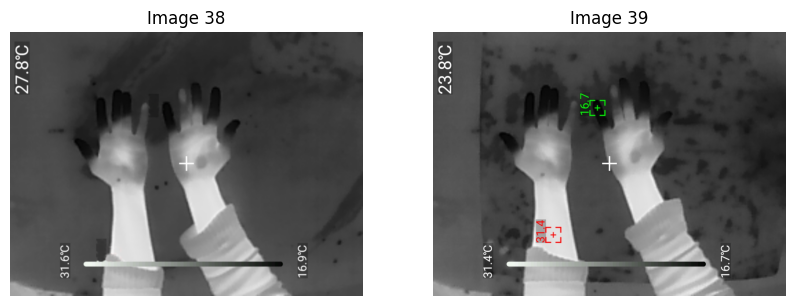

In [60]:
image_39_path = "../../resources/evaluation_dataset/IR/39_IMG20241127102649.jpg"
image_39_name = "39_IMG20241127102649.jpg"
image_38_path = "../../resources/evaluation_dataset/IR/38_IMG20241127102643.jpg"
image_38_name = "38_IMG20241127102643.jpg"


with open('../../resources/evaluation_dataset/IR_annotations/combined_FIX_IR.json', 'r') as f:
    ground_truth_data = json.load(f)
            
ground_truth_landmarks_39 = ground_truth_data[38]['landmarks']
ground_truth_landmarks_38 = ground_truth_data[37]['landmarks']

ground_truth_landmarks_38 = rotate_landmarks_90_counterclockwise(ground_truth_landmarks_38)
ground_truth_landmarks_39 = rotate_landmarks_90_counterclockwise(ground_truth_landmarks_39)

# Rotate both images
image = cv2.imread(image_38_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_path = f"../../resources/stylized-pictures/rotated/{image_38_name}_rotated.png"
cv2.imwrite(rotated_path, rotated)
image_38_path = rotated_path

image = cv2.imread(image_39_path)
rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
rotated_path = f"../../resources/stylized-pictures/rotated/{image_39_name}_rotated.png"
cv2.imwrite(rotated_path, rotated)
image_39_path = rotated_path

# Remove temperature boxes
no_boxes_image_path_38 = remove_temperature_boxes(image_38_path, image_38_name)
no_boxes_image_path_39 = remove_temperature_boxes(image_39_path, image_39_name)

    
# Plot both pictures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(cv2.imread(no_boxes_image_path_38), cv2.COLOR_BGR2RGB))
ax[0].set_title("Image 38")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(cv2.imread(image_39_path), cv2.COLOR_BGR2RGB))
ax[1].set_title("Image 39")
ax[1].axis('off')

plt.show()

In [61]:
image_path = "../../resources/evaluation_dataset/IR/37_IMG20241127102538.jpg"
image_name = "37_IMG20241127102538.jpg"

json_file_path = "../../resources/evaluation_dataset/IR_annotations/combined_FIX_IR.json"
with open(json_file_path, 'r') as f:
    ground_truth_data = json.load(f)

ground_truth_landmarks = ground_truth_data[36]['landmarks']

# Rotate image and landmarks 90 degrees counterclockwise
image = cv2.imread(image_path)
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
image_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
cv2.imwrite(image_path, image)

ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)

# Visualize the threshold
visualize_threshold_roi(image_path, ground_truth_landmarks, distance_threshold, '../../resources/paper/roi_threshold.png')


In [62]:
# Annotate landmarks
image = cv2.imread('../../resources/paper/roi_threshold.png')
annotated_image = draw_landmarks_on_image_from_json(image, {'landmarks': ground_truth_landmarks})
cv2.imwrite('../../resources/paper/roi_threshold_annotated.png', annotated_image)

True

# Ploting image 80 intermediary results

In [63]:
image_score_image_path = {
    "Original Accuracy": {},
    "First Pipeline": {},
    "Second Pipeline": {},
    "Third Pipeline": {},
}

In [67]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            if image_name != "80_IMG20241127105346.jpg":
                continue
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            results = gesture_recognizer.recognize(mp.Image.create_from_file(first_pipeline_image_path))
            annotated = draw_landmarks_on_image(cv2.imread(first_pipeline_image_path), results)
            cv2.imwrite(f"../../resources/paper/80_first_pipeline.png", annotated)
            
            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            second_pipeline_score = assess_accuracy(second_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for second pipeline - Left: {np.mean(second_pipeline_score['Left']):.2f}%, Right: {np.mean(second_pipeline_score['Right']):.2f}%")
            
            third_pipeline_image_path = advanced_enhancement(image_path, image_name)
            third_pipeline_score = assess_accuracy(third_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for third pipeline - Left: {np.mean(third_pipeline_score['Left']):.2f}%, Right: {np.mean(third_pipeline_score['Right']):.2f}%")
            
            # fourth_pipeline_image_path = fourth_pipeline(image_path, image_name)
            # fourth_pipeline_score = assess_accuracy(fourth_pipeline_image_path, ground_truth_landmarks)
            # print(f"Results for fourth pipeline - Left: {np.mean(fourth_pipeline_score['Left']):.2f}%, Right: {np.mean(fourth_pipeline_score['Right']):.2f}%")
            
            image = mp.Image.create_from_file(first_pipeline_image_path)
            recognizer_results_first_pipeline = gesture_recognizer.recognize(image)
            first_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_first_pipeline)
            
            image = mp.Image.create_from_file(second_pipeline_image_path)
            recognizer_results_second_pipeline = gesture_recognizer.recognize(image)
            second_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_second_pipeline)
            
            image = mp.Image.create_from_file(third_pipeline_image_path)
            recognizer_results_third_pipeline = gesture_recognizer.recognize(image)
            third_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_third_pipeline)
            
            # image = mp.Image.create_from_file(fourth_pipeline_image_path)
            # recognizer_results_fourth_pipeline = gesture_recognizer.recognize(image)
            # fourth_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_fourth_pipeline)
            
            # Initialize landmarks_gestures_score dictionary
            landmarks_gestures_score = {"Left": [], "Right": []}
            
            # Check if landmarks exist for each pipeline and append them accordingly
            if "Left" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(first_pipeline_gesture_score_landmarks["Left"])
            if "Right" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(first_pipeline_gesture_score_landmarks["Right"])
            
            if "Left" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(second_pipeline_gesture_score_landmarks["Left"])
            if "Right" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(second_pipeline_gesture_score_landmarks["Right"])
            
            if "Left" in third_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(third_pipeline_gesture_score_landmarks["Left"])
            if "Right" in third_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(third_pipeline_gesture_score_landmarks["Right"])
                
            # if "Left" in fourth_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Left"].append(fourth_pipeline_gesture_score_landmarks["Left"])
            # if "Right" in fourth_pipeline_gesture_score_landmarks:
            #     landmarks_gestures_score["Right"].append(fourth_pipeline_gesture_score_landmarks["Right"])
                
            final_landmarks = []
            
            for hand in ["Left", "Right"]:
                all_available_landmarks = landmarks_gestures_score[hand]
                
                if not all_available_landmarks:
                    continue
            
                # Step 1: Filter only open palm gestures
                open_palm_landmarks = [l for l in all_available_landmarks if l['gestures'] == 'Open_Palm']
            
                # Step 2: Handle multiple open palms
                if len(open_palm_landmarks) > 1:
                    merged_landmarks = merge_landmarks(open_palm_landmarks, hand)
                    final_landmarks.append(merged_landmarks)
            
                # Step 3: Handle a single open palm
                elif len(open_palm_landmarks) == 1:
                    final_landmarks.append(open_palm_landmarks[0]['landmarks'])
            
                # Step 4: No open palm detected, use lowest score gesture
                else:
                    lowest_score_landmark = min(all_available_landmarks, key=lambda l: l['score'])
                    final_landmarks.append(lowest_score_landmark['landmarks'])

                        
            final_landmark_accuracy = calculate_hand_accuracies(ground_truth_landmarks, final_landmarks, ["Left", "Right"], distance_threshold)
            final_landmark_accuracy["Left"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Left"])) else final_landmark_accuracy["Left"]
            final_landmark_accuracy["Right"] = [0.0]*21 if np.isnan(np.mean(final_landmark_accuracy["Right"])) else final_landmark_accuracy["Right"]
            print(f"Results for final score - Left: {np.mean(final_landmark_accuracy['Left']):.2f}%, Right: {np.mean(final_landmark_accuracy['Right']):.2f}%")

            # Annotate with final landmarks
            annotated_image_path = f"../../resources/stylized-pictures/annotated/{image_name}_annotated.png"
            annotate_landmarks(image_path, final_landmarks, annotated_image_path)

            print("---------------------------------------------------------")

          
            for hand in ["Left", "Right"]:
                total_transformed_siggraph17[hand].extend(final_landmark_accuracy[hand])



Processing image: 80_IMG20241127105346.jpg
Results for original pipeline - Left: 13.17%, Right: 69.18%
Results for second pipeline - Left: 11.97%, Right: 72.68%
Results for third pipeline - Left: 70.32%, Right: 62.28%
Results for final score - Left: 70.32%, Right: 74.87%
---------------------------------------------------------


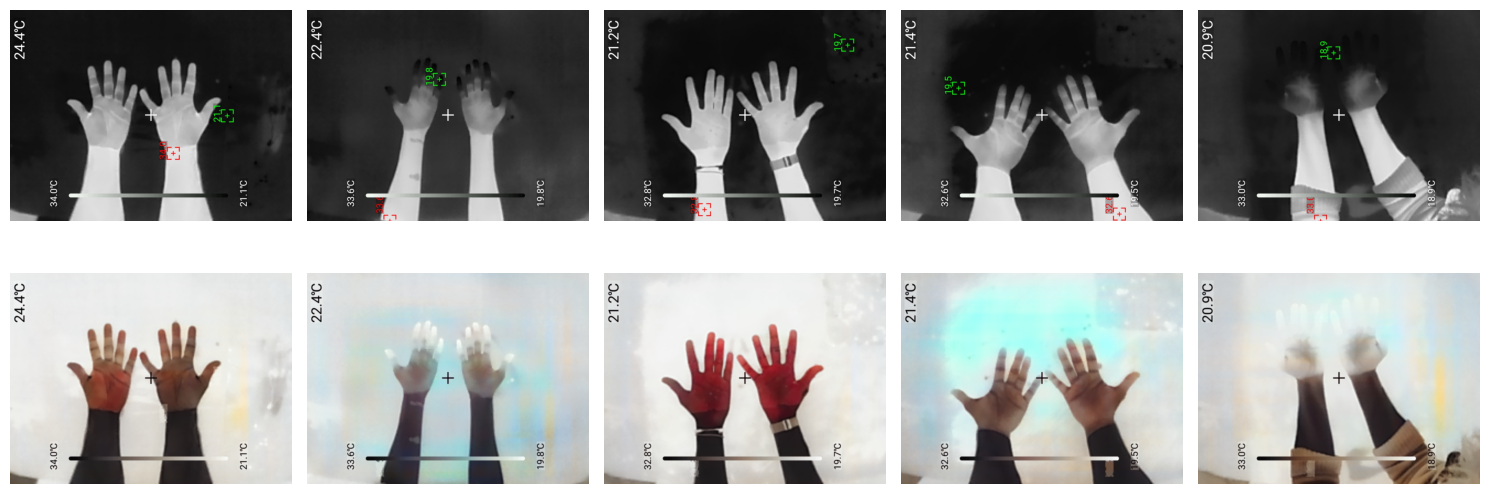

In [65]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Paths to the folders
folder1 = '../../resources/paper/different colorization/original'
folder2 = '../../resources/paper/different colorization/siggraph'

# Get a list of image files in each folder
images1 = sorted([os.path.join(folder1, f) for f in os.listdir(folder1) if f.endswith(('png', 'jpg', 'jpeg'))])
images2 = sorted([os.path.join(folder2, f) for f in os.listdir(folder2) if f.endswith(('png', 'jpg', 'jpeg'))])

# Select 5 images from each folder
selected_images1 = images1[:5]
selected_images2 = images2[:5]

# Combine into two rows
row1 = selected_images1
row2 = selected_images2

# Create the plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot row 1
for i, img_path in enumerate(row1):
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')  # Hide axis

# Plot row 2
for i, img_path in enumerate(row2):
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [66]:
ground_truth_landmarks = ground_truth_data[79]['landmarks']

# Rotate image and landmarks 90 degrees counterclockwise
ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)

image = mp.Image.create_from_file("../../resources/paper/1.jpg")
recognizer_results = gesture_recognizer.recognize(image)
score = assess_accuracy("../../resources/paper/1.jpg", ground_truth_landmarks)
print(f"Results for no boxes - Left: {np.mean(score['Left']):.2f}%, Right: {np.mean(score['Right']):.2f}%")

image = mp.Image.create_from_file("../../resources/paper/2.jpg")
recognizer_results = gesture_recognizer.recognize(image)
score = assess_accuracy("../../resources/paper/2.jpg", ground_truth_landmarks)
print(f"Results for no boxes - Left: {np.mean(score['Left']):.2f}%, Right: {np.mean(score['Right']):.2f}%")

image = mp.Image.create_from_file("../../resources/paper/3.jpg")
recognizer_results = gesture_recognizer.recognize(image)
score = assess_accuracy("../../resources/paper/3.jpg", ground_truth_landmarks)
print(f"Results for no boxes - Left: {np.mean(score['Left']):.2f}%, Right: {np.mean(score['Right']):.2f}%")


RuntimeError: Image decoding failed (can't fopen): ../../resources/paper/1.jpg

In [ ]:
first_pipeline_folder = "../../resources/paper/80 main visual/first"
second_pipeline_folder = "../../resources/paper/80 main visual/second"

first_operation = ["Removing Temperature Boxes", "Negative", "Colorized"]
second_operation = ["Removing Temperature Boxes", "CLAHE", "Sharpened"]

first_pipeline_scores = 

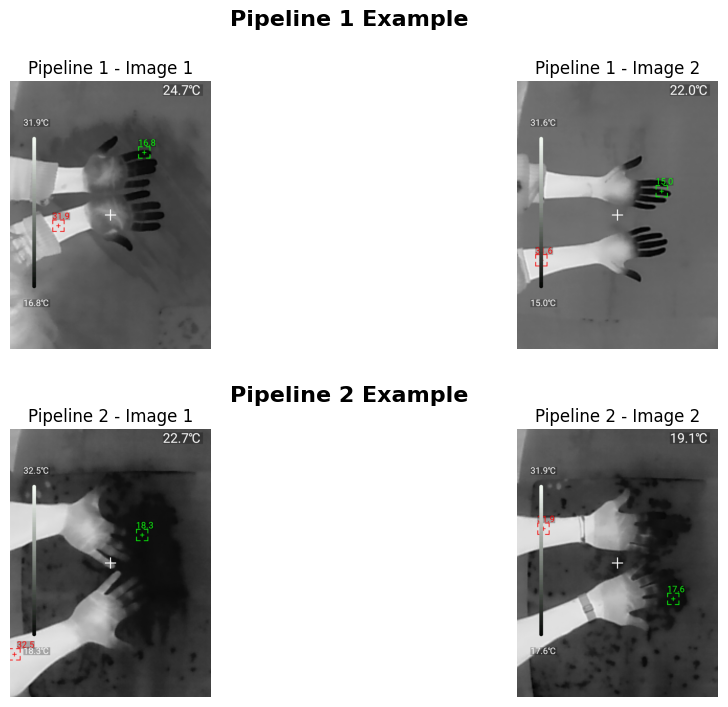

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

# Load the images (replace with your actual image paths)
image1 = Image.open('../../resources/evaluation_dataset/IR/42_IMG20241127102854.jpg')
image2 = Image.open('../../resources/evaluation_dataset/IR/11_IMG20241127100906.jpg')
image3 = Image.open('../../resources/evaluation_dataset/IR/71_IMG20241127103908.jpg')
image4 = Image.open('../../resources/evaluation_dataset/IR/57_IMG20241127103455.jpg')

# Create a figure
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.2)

# Part 1: Pipeline 1 Example
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.imshow(image1)
ax1.set_title("Pipeline 1 - Image 1")
ax1.axis('off')
ax2.imshow(image2)
ax2.set_title("Pipeline 1 - Image 2")
ax2.axis('off')

# Part 2: Pipeline 2 Example
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax3.imshow(image3)
ax3.set_title("Pipeline 2 - Image 1")
ax3.axis('off')
ax4.imshow(image4)
ax4.set_title("Pipeline 2 - Image 2")
ax4.axis('off')

# Add captions for each part
fig.text(0.5, 0.95, "Pipeline 1 Example", ha='center', fontsize=16, fontweight='bold')
fig.text(0.5, 0.48, "Pipeline 2 Example", ha='center', fontsize=16, fontweight='bold')

# Save the figure (for Overleaf compatibility, save as PDF or PNG)
plt.savefig('comparison_figure.png', dpi=300, bbox_inches='tight')

plt.show()


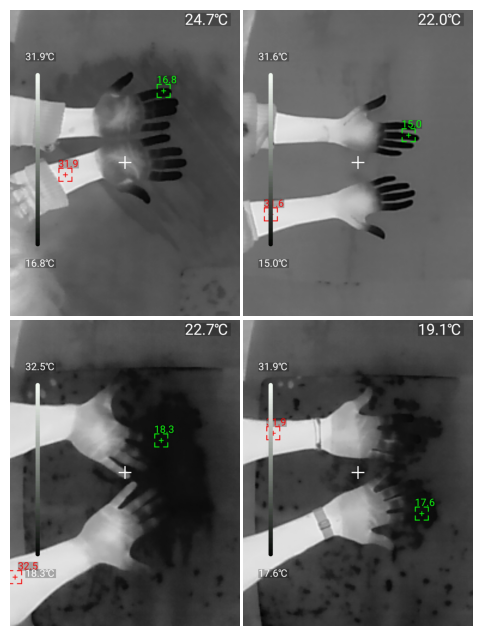

In [8]:
# Create a figure with 2 rows and 2 columns, adjusting spacing to minimize white space
fig, axs = plt.subplots(2, 2, figsize=(6, 8), gridspec_kw={'wspace': 0.0, 'hspace': 0.01})

# Display the images
axs[0, 0].imshow(image1)
axs[0, 0].axis('off')
axs[0, 1].imshow(image2)
axs[0, 1].axis('off')
axs[1, 0].imshow(image3)
axs[1, 0].axis('off')
axs[1, 1].imshow(image4)
axs[1, 1].axis('off')

# Save the figure (for Overleaf compatibility, save as PDF or PNG)
plt.savefig('comparison_figure.png', dpi=300, bbox_inches='tight')
plt.savefig('comparison_figure.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [9]:
import cv2

image_path = '../../resources/paper/80 main visual/first/3.png'

results = gesture_recognizer.recognize(mp.Image.create_from_file(image_path))

annotated = draw_landmarks_on_image(cv2.imread(image_path), results)

cv2.imwrite('../../resources/paper/80 main visual/first/3_annotated.jpg', annotated)


True

# Try on original data


In [139]:
# Process each image
for file_name in os.listdir('../../resources/evaluation_dataset/Old/LC_AW_WM'):

        image_path = f"../../resources/evaluation_dataset/Old/LC_AW_WM/{file_name}"
        
        image = cv2.imread(image_path)
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        rotated_path = f"../../resources/stylized-pictures/rotated/{file_name}_rotated.png"
        cv2.imwrite(rotated_path, rotated)
        image_path = rotated_path
        
        
        print(f"Processing image: {file_name}")

        first_pipeline_image_path = execute_transformation_pipeline(image_path, file_name)
        
        second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, file_name)
        
        image = mp.Image.create_from_file(first_pipeline_image_path)
        recognizer_results_first_pipeline = gesture_recognizer.recognize(image)
        first_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_first_pipeline)
        
        image = mp.Image.create_from_file(second_pipeline_image_path)
        recognizer_results_second_pipeline = gesture_recognizer.recognize(image)
        second_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_second_pipeline)
        
        
        # Initialize landmarks_gestures_score dictionary
        landmarks_gestures_score = {"Left": [], "Right": []}
        
        # Check if landmarks exist for each pipeline and append them accordingly
        if "Left" in first_pipeline_gesture_score_landmarks:
            landmarks_gestures_score["Left"].append(first_pipeline_gesture_score_landmarks["Left"])
        if "Right" in first_pipeline_gesture_score_landmarks:
            landmarks_gestures_score["Right"].append(first_pipeline_gesture_score_landmarks["Right"])
        
        if "Left" in second_pipeline_gesture_score_landmarks:
            landmarks_gestures_score["Left"].append(second_pipeline_gesture_score_landmarks["Left"])
        if "Right" in second_pipeline_gesture_score_landmarks:
            landmarks_gestures_score["Right"].append(second_pipeline_gesture_score_landmarks["Right"])
        
        final_landmarks = []
        
        for hand in ["Left", "Right"]:
            all_available_landmarks = landmarks_gestures_score[hand]
            
            if not all_available_landmarks:
                continue
        
            # Step 1: Filter only open palm gestures
            open_palm_landmarks = [l for l in all_available_landmarks if l['gestures'] == 'Open_Palm']
        
            # Step 2: Handle multiple open palms
            if len(open_palm_landmarks) > 1:
                merged_landmarks = merge_landmarks(open_palm_landmarks, hand)
                final_landmarks.append(merged_landmarks)
        
            # Step 3: Handle a single open palm
            elif len(open_palm_landmarks) == 1:
                final_landmarks.append(open_palm_landmarks[0]['landmarks'])
        
            # Step 4: No open palm detected, use lowest score gesture
            else:
                lowest_score_landmark = min(all_available_landmarks, key=lambda l: l['score'])
                final_landmarks.append(lowest_score_landmark['landmarks'])


        # Annotate with final landmarks
        annotated_image_path = f"../../resources/evaluation_dataset/Old/LC_AW_WM_annotated/{file_name}_annotated.png"
        annotate_landmarks(image_path, final_landmarks, annotated_image_path)

        print("---------------------------------------------------------")




Processing image: frame1.jpg
---------------------------------------------------------
Processing image: frame10.jpg
---------------------------------------------------------
Processing image: frame11.jpg
---------------------------------------------------------
Processing image: frame12.jpg
---------------------------------------------------------
Processing image: frame13.jpg
---------------------------------------------------------
Processing image: frame14.jpg
---------------------------------------------------------
Processing image: frame15.jpg
---------------------------------------------------------
Processing image: frame16.jpg
---------------------------------------------------------
Processing image: frame17.jpg
---------------------------------------------------------
Processing image: frame18.jpg
---------------------------------------------------------
Processing image: frame19.jpg
---------------------------------------------------------
Processing image: frame2.jpg
----

# Plotting Colorization Results

In [101]:
def colorize(image_path, image_name, colorization_model='siggraph17'):
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(image_path, image_name)
    
    return transformed_image_path
    

In [102]:
def colorize_with_inversion(image_path, image_name, colorization_model='siggraph17'):
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(image_path))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [149]:
eccv_alone = {"Left": [], "Right": []}
eccv_invertion = {"Left": [], "Right": []}

siggraph_alone = {"Left": [], "Right": []}
siggraph_invertion = {"Left": [], "Right": []}

In [150]:
#Thresholds Metric
thresholds = [0.025, 0.05, 0.07]
eccv_alone_thresholds = {t: {"Left": [], "Right": []} for t in thresholds}
eccv_invertion_thresholds = {t: {"Left": [], "Right": []} for t in thresholds}

siggraph_alone_thresholds = {t: {"Left": [], "Right": []} for t in thresholds}
siggraph_invertion_thresholds = {t: {"Left": [], "Right": []} for t in thresholds}

final_pipeline_thresholds = {t: {"Left": [], "Right": []} for t in thresholds}

In [151]:
# Threshold for PCK
pck_thresholds = [0.025, 0.05, 0.07]
eccv_alone_thresholds_pck = {t: {"Left": [], "Right": []} for t in pck_thresholds}
eccv_invertion_thresholds_pck = {t: {"Left": [], "Right": []} for t in pck_thresholds}

siggraph_alone_thresholds_pck = {t: {"Left": [], "Right": []} for t in pck_thresholds}
siggraph_invertion_thresholds_pck = {t: {"Left": [], "Right": []} for t in pck_thresholds}

final_pipeline_thresholds_pck = {t: {"Left": [], "Right": []} for t in pck_thresholds}

In [168]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            if image_name != '65_IMG20241127103717.jpg':
                continue
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"

            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            # first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            # first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            # print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            colorized_siggraph17 = colorize(image_path, image_name, 'siggraph17')
            colorized_siggraph17_pck = assess_pck_accuracy(colorized_siggraph17, ground_truth_landmarks, 0.05)
            print(f"Results for Siggraph17 PCK - Left: {colorized_siggraph17_pck['Left'] * 100:.2f}%, Right: {colorized_siggraph17_pck['Right'] * 100:.2f}%")
            colorized_eccv16 = colorize(image_path, image_name, 'eccv16')
            colorized_eccv16_pck = assess_pck_accuracy(colorized_eccv16, ground_truth_landmarks, 0.05)
            print(f"Results for ECCV16 PCK - Left: {colorized_eccv16_pck['Left'] * 100:.2f}%, Right: {colorized_eccv16_pck['Right'] * 100:.2f}%")
            
             # Calculate accuracy
            colorized_siggraph_score = assess_accuracy(colorized_siggraph17, ground_truth_landmarks)
            print(f"Results for Siggraph17 - Left: {np.mean(colorized_siggraph_score['Left']):.2f}%, Right: {np.mean(colorized_siggraph_score['Right']):.2f}%")
            colorized_eccv16_score = assess_accuracy(colorized_eccv16, ground_truth_landmarks)
            print(f"Results for ECCV16 - Left: {np.mean(colorized_eccv16_score['Left']):.2f}%, Right: {np.mean(colorized_eccv16_score['Right']):.2f}%")

            # Calculate Accuracy for Thresholds Metrics
            for t in thresholds:
                colorized_siggraph17_score = assess_accuracy(colorized_siggraph17, ground_truth_landmarks, t)
                colorized_eccv16_score = assess_accuracy(colorized_eccv16, ground_truth_landmarks, t)

                for hand in ["Left", "Right"]:
                    eccv_alone_thresholds[t][hand].extend(colorized_eccv16_score[hand])
                    siggraph_alone_thresholds[t][hand].extend(colorized_siggraph17_score[hand])


            # Calculate Accuracy for PCK Metrics
            for t in pck_thresholds:

                colorized_siggraph17_score = assess_pck(colorized_siggraph17, ground_truth_landmarks, t)
                colorized_eccv16_score = assess_pck(colorized_eccv16, ground_truth_landmarks, t)

                for hand in ["Left", "Right"]:
                    eccv_alone_thresholds_pck[t][hand].append(colorized_eccv16_score[hand])
                    siggraph_alone_thresholds_pck[t][hand].append(colorized_siggraph17_score[hand])
    
                    
            
            colorized_siggraph17_inverted = colorize_with_inversion(image_path, image_name, 'siggraph17')
            colorized_siggraph_inverted_pck = assess_pck_accuracy(colorized_siggraph17_inverted, ground_truth_landmarks, 0.05)
            print(f"Results for Siggraph17 Inverted PCK - Left: {colorized_siggraph_inverted_pck['Left'] * 100:.2f}%, Right: {colorized_siggraph_inverted_pck['Right'] * 100:.2f}%")
            colorized_eccv16_inverted = colorize_with_inversion(image_path, image_name, 'eccv16')
            colorized_eccv16_inverted_pck = assess_pck_accuracy(colorized_eccv16_inverted, ground_truth_landmarks, 0.05)
            print(f"Results for ECCV16 Inverted PCK - Left: {colorized_eccv16_inverted_pck['Left'] * 100:.2f}%, Right: {colorized_eccv16_inverted_pck['Right'] * 100:.2f}%")
            
            # Calculate Accuracy for Thresholds Metrics
            for t in thresholds:
                colorized_siggraph17_inverted_score = assess_accuracy(colorized_siggraph17_inverted, ground_truth_landmarks, t)
                colorized_eccv16_inverted_score = assess_accuracy(colorized_eccv16_inverted, ground_truth_landmarks, t)

                for hand in ["Left", "Right"]:
                    eccv_invertion_thresholds[t][hand].extend(colorized_eccv16_inverted_score[hand])
                    siggraph_invertion_thresholds[t][hand].extend(colorized_siggraph17_inverted_score[hand])

            # Calculate Accuracy for PCK Metrics
            for t in pck_thresholds:

                    colorized_siggraph17_inverted_score = assess_pck(colorized_siggraph17_inverted, ground_truth_landmarks, t)
                    colorized_eccv16_inverted_score = assess_pck(colorized_eccv16_inverted, ground_truth_landmarks, t)

                    for hand in ["Left", "Right"]:
                        eccv_invertion_thresholds_pck[t][hand].append(colorized_eccv16_inverted_score[hand])
                        siggraph_invertion_thresholds_pck[t][hand].append(colorized_siggraph17_inverted_score[hand])
                    
                    
                    
            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            
            # Calculate accuracy
            for t in thresholds:
                colorized_siggraph17_final = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks, t)

                for hand in ["Left", "Right"]:
                    final_pipeline_thresholds[t][hand].extend(colorized_siggraph17_final[hand])

            for t in pck_thresholds:
                colorized_siggraph17_final = assess_pck(first_pipeline_image_path, ground_truth_landmarks, t)

                for hand in ["Left", "Right"]:
                    final_pipeline_thresholds_pck[t][hand].append(colorized_siggraph17_final[hand])





            colorized_siggraph_inverted_score = assess_accuracy(colorized_siggraph17_inverted, ground_truth_landmarks)
            print(f"Results for Siggraph17 Inverted - Left: {np.mean(colorized_siggraph_inverted_score['Left']):.2f}%, Right: {np.mean(colorized_siggraph_inverted_score['Right']):.2f}%")
            colorized_eccv16_inverted_score = assess_accuracy(colorized_eccv16_inverted, ground_truth_landmarks)
            print(f"Results for ECCV16 Inverted - Left: {np.mean(colorized_eccv16_inverted_score['Left']):.2f}%, Right: {np.mean(colorized_eccv16_inverted_score['Right']):.2f}%")
            
            # # Add to appropriate dictionaries
            # for hand in ["Left", "Right"]:
            #     eccv_alone[hand].extend(colorized_eccv16_score[hand])
            #     eccv_invertion[hand].extend(colorized_eccv16_inverted_score[hand])
            # 
            #     siggraph_alone[hand].extend(colorized_siggraph_score[hand])
            #     siggraph_invertion[hand].extend(colorized_siggraph_inverted_score[hand])


            print("---------------------------------------------------------")



Processing image: 65_IMG20241127103717.jpg
Colorizing 65_IMG20241127103717.jpg using Zhang SIGGRAPH17 model...
Results for Siggraph17 PCK - Left: 0.00%, Right: 0.00%
Colorizing 65_IMG20241127103717.jpg using Zhang ECCV16 model...
Results for ECCV16 PCK - Left: 85.71%, Right: 0.00%
Results for Siggraph17 - Left: 0.00%, Right: 0.00%
Results for ECCV16 - Left: 75.65%, Right: 0.00%
No hands detected for ../../resources/stylized-pictures/siggraph17/65_IMG20241127103717.jpg_siggraph17.png
No hands detected for ../../resources/stylized-pictures/siggraph17/65_IMG20241127103717.jpg_siggraph17.png
No hands detected for ../../resources/stylized-pictures/siggraph17/65_IMG20241127103717.jpg_siggraph17.png
Colorizing 65_IMG20241127103717.jpg using Zhang SIGGRAPH17 model...
Results for Siggraph17 Inverted PCK - Left: 95.24%, Right: 90.48%
Colorizing 65_IMG20241127103717.jpg using Zhang ECCV16 model...
Results for ECCV16 Inverted PCK - Left: 90.48%, Right: 90.48%
Colorizing 65_IMG20241127103717.jpg us

In [167]:
# Calculate final accuracy
eccv_alone_accuracy = calculate_final_accuracy(eccv_alone)
eccv_invertion_accuracy = calculate_final_accuracy(eccv_invertion)

siggraph_alone_accuracy = calculate_final_accuracy(siggraph_alone)
siggraph_invertion_accuracy = calculate_final_accuracy(siggraph_invertion)

In [154]:
print(f"ECCV16 Alone Accuracy: {eccv_alone_accuracy:.2f}%")
print(f"ECCV16 Invertion Accuracy: {eccv_invertion_accuracy:.2f}%")

print(f"Siggraph17 Alone Accuracy: {siggraph_alone_accuracy:.2f}%")
print(f"Siggraph17 Invertion Accuracy: {siggraph_invertion_accuracy:.2f}%")

ECCV16 Alone Accuracy: 0.00%
ECCV16 Invertion Accuracy: 0.00%
Siggraph17 Alone Accuracy: 0.00%
Siggraph17 Invertion Accuracy: 0.00%


In [155]:
# Calculate final accuracy for Thresholds Metrics
eccv_alone_thresholds_accuracy = {t: calculate_final_accuracy(eccv_alone_thresholds[t]) for t in thresholds}
eccv_invertion_thresholds_accuracy = {t: calculate_final_accuracy(eccv_invertion_thresholds[t]) for t in thresholds}

siggraph_alone_thresholds_accuracy = {t: calculate_final_accuracy(siggraph_alone_thresholds[t]) for t in thresholds}
siggraph_invertion_thresholds_accuracy = {t: calculate_final_accuracy(siggraph_invertion_thresholds[t]) for t in thresholds}

In [156]:
# Calculate final accuracy for PCK Metrics
eccv_alone_thresholds_pck_accuracy = {t: calculate_final_accuracy(eccv_alone_thresholds_pck[t]) for t in pck_thresholds}
eccv_invertion_thresholds_pck_accuracy = {t: calculate_final_accuracy(eccv_invertion_thresholds_pck[t]) for t in pck_thresholds}

siggraph_alone_thresholds_pck_accuracy = {t: calculate_final_accuracy(siggraph_alone_thresholds_pck[t]) for t in pck_thresholds}
siggraph_invertion_thresholds_pck_accuracy = {t: calculate_final_accuracy(siggraph_invertion_thresholds_pck[t]) for t in pck_thresholds}


In [157]:
print("ECCV16 Alone Thresholds Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {eccv_alone_thresholds_accuracy[t]:.2f}%")
    
print("ECCV16 Invertion Thresholds Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {eccv_invertion_thresholds_accuracy[t]:.2f}%")
    
print("Siggraph17 Alone Thresholds Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {siggraph_alone_thresholds_accuracy[t]:.2f}%")
    
print("Siggraph17 Invertion Thresholds Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {siggraph_invertion_thresholds_accuracy[t]:.2f}%")
    
    

ECCV16 Alone Thresholds Accuracy
Threshold: 0.025, Accuracy: 25.28%
Threshold: 0.05, Accuracy: 37.11%
Threshold: 0.07, Accuracy: 41.41%
ECCV16 Invertion Thresholds Accuracy
Threshold: 0.025, Accuracy: 29.05%
Threshold: 0.05, Accuracy: 44.18%
Threshold: 0.07, Accuracy: 50.04%
Siggraph17 Alone Thresholds Accuracy
Threshold: 0.025, Accuracy: 21.05%
Threshold: 0.05, Accuracy: 30.56%
Threshold: 0.07, Accuracy: 33.99%
Siggraph17 Invertion Thresholds Accuracy
Threshold: 0.025, Accuracy: 35.33%
Threshold: 0.05, Accuracy: 52.25%
Threshold: 0.07, Accuracy: 58.53%


In [158]:
print("ECCV16 Alone PCK Accuracy")
for t in pck_thresholds:
    print(f"Threshold: {t}, Accuracy: {eccv_alone_thresholds_pck_accuracy[t] * 100:.2f}%")
    
print("ECCV16 Invertion PCK Accuracy")
for t in pck_thresholds:
    print(f"Threshold: {t}, Accuracy: {eccv_invertion_thresholds_pck_accuracy[t] * 100:.2f}%")
    
print("Siggraph17 Alone PCK Accuracy")
for t in pck_thresholds:
    print(f"Threshold: {t}, Accuracy: {siggraph_alone_thresholds_pck_accuracy[t] * 100:.2f}%")
    
print("Siggraph17 Invertion PCK Accuracy")
for t in pck_thresholds:
    print(f"Threshold: {t}, Accuracy: {siggraph_invertion_thresholds_pck_accuracy[t] * 100:.2f}%")

ECCV16 Alone PCK Accuracy
Threshold: 0.025, Accuracy: 19.55%
Threshold: 0.05, Accuracy: 38.15%
Threshold: 0.07, Accuracy: 44.79%
ECCV16 Invertion PCK Accuracy
Threshold: 0.025, Accuracy: 22.02%
Threshold: 0.05, Accuracy: 45.57%
Threshold: 0.07, Accuracy: 53.48%
Siggraph17 Alone PCK Accuracy
Threshold: 0.025, Accuracy: 17.29%
Threshold: 0.05, Accuracy: 31.76%
Threshold: 0.07, Accuracy: 36.70%
Siggraph17 Invertion PCK Accuracy
Threshold: 0.025, Accuracy: 28.12%
Threshold: 0.05, Accuracy: 53.72%
Threshold: 0.07, Accuracy: 62.56%


In [159]:
# Calculate final accuracy for Thresholds Metrics
final_pipeline_thresholds_accuracy = {t: calculate_final_accuracy(final_pipeline_thresholds[t]) for t in thresholds}

# Calculate final accuracy for PCK Metrics
final_pipeline_thresholds_pck_accuracy = {t: calculate_final_accuracy(final_pipeline_thresholds_pck[t]) for t in pck_thresholds}

In [160]:
print("Final Pipeline Thresholds Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {final_pipeline_thresholds_accuracy[t]:.2f}%")
    
print("Final Pipeline PCK Accuracy")
for t in pck_thresholds:
    print(f"Threshold: {t}, Accuracy: {final_pipeline_thresholds_pck_accuracy[t] * 100:.2f}%")

Final Pipeline Thresholds Accuracy
Threshold: 0.025, Accuracy: 39.75%
Threshold: 0.05, Accuracy: 58.52%
Threshold: 0.07, Accuracy: 65.51%
Final Pipeline PCK Accuracy
Threshold: 0.025, Accuracy: 31.46%
Threshold: 0.05, Accuracy: 60.21%
Threshold: 0.07, Accuracy: 70.21%


In [148]:
# Get upper bounds and lower bounds for each threshold
thresholds = [0.025, 0.05, 0.07]

for t in thresholds:
    print(f"Threshold: {t}")
    print(f"Upper Bound (Metric): {calculate_bound_accuracy(RGB_image_directory, RGB_ground_truth_directory, t):.2f}%")
    print(f"Lower Bound (Metric): {calculate_bound_accuracy(IR_image_directory, IR_ground_truth_directory, t):.2f}%")
    
    print(f"Upper Bound (PCK): {calculate_bound_pck(RGB_image_directory, RGB_ground_truth_directory, t) * 100:.2f}%")
    print(f"Lower Bound (PCK): {calculate_bound_pck(IR_image_directory, IR_ground_truth_directory, t) * 100:.2f}%")


Threshold: 0.025
Upper Bound (Metric): 68.93%
Lower Bound (Metric): 29.53%
Upper Bound (PCK): 55.29%
No hands detected for ../../resources/evaluation_dataset/IR\3_IMG20241127100408.jpg
No hands detected for ../../resources/evaluation_dataset/IR\5_IMG20241127100507.jpg
No hands detected for ../../resources/evaluation_dataset/IR\6_IMG20241127100515.jpg
No hands detected for ../../resources/evaluation_dataset/IR\10_IMG20241127100740.jpg
No hands detected for ../../resources/evaluation_dataset/IR\11_IMG20241127100906.jpg
No hands detected for ../../resources/evaluation_dataset/IR\12_IMG20241127100913.jpg
No hands detected for ../../resources/evaluation_dataset/IR\13_IMG20241127101012.jpg
No hands detected for ../../resources/evaluation_dataset/IR\14_IMG20241127101019.jpg
No hands detected for ../../resources/evaluation_dataset/IR\29_IMG20241127102051.jpg
No hands detected for ../../resources/evaluation_dataset/IR\38_IMG20241127102643.jpg
No hands detected for ../../resources/evaluation_dat

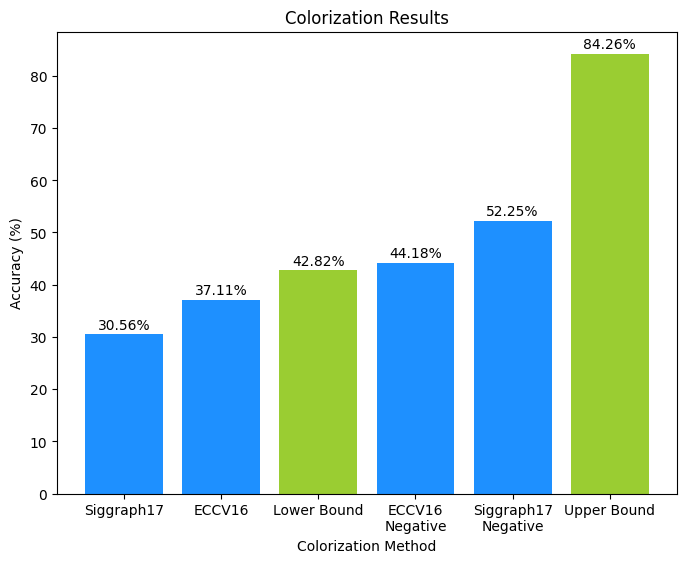

In [84]:
# Updated titles with newline characters to place "Negative" below
titles = ['Siggraph17', 'ECCV16', 'Lower Bound', 'ECCV16\nNegative', 'Siggraph17\nNegative', 'Upper Bound']
data = [siggraph_alone_accuracy, eccv_alone_accuracy, lower_bound_accuracy, eccv_invertion_accuracy, siggraph_invertion_accuracy, upper_bound_accuracy]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(titles, data, color=['dodgerblue', 'dodgerblue', 'yellowgreen', 'dodgerblue', 'dodgerblue', 'yellowgreen'])

# Add data labels
for i, v in enumerate(data):
    ax.text(i, v + 1, f"{v:.2f}%", color='black', ha='center')

ax.set_xlabel('Colorization Method')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Colorization Results')
plt.show()


In [85]:
image_path = '../../resources/evaluation_dataset/IR/65_IMG20241127103717.jpg'
colorize(image_path, '65_IMG20241127103717.jpg_not_inverted', 'siggraph17')
colorize(image_path, '65_IMG20241127103717.jpg_inverted', 'eccv16')

Colorizing 65_IMG20241127103717.jpg_not_inverted using Zhang SIGGRAPH17 model...
Colorizing 65_IMG20241127103717.jpg_inverted using Zhang ECCV16 model...


C:\Users\zosia\Desktop\Studies\Research Project\implementations-of-techniques\src\colorization\Zhang\util.py:47: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42 negative Z values that have been clipped to zero
  return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))


'../../resources/stylized-pictures/eccv16/65_IMG20241127103717.jpg_inverted_eccv16.png'

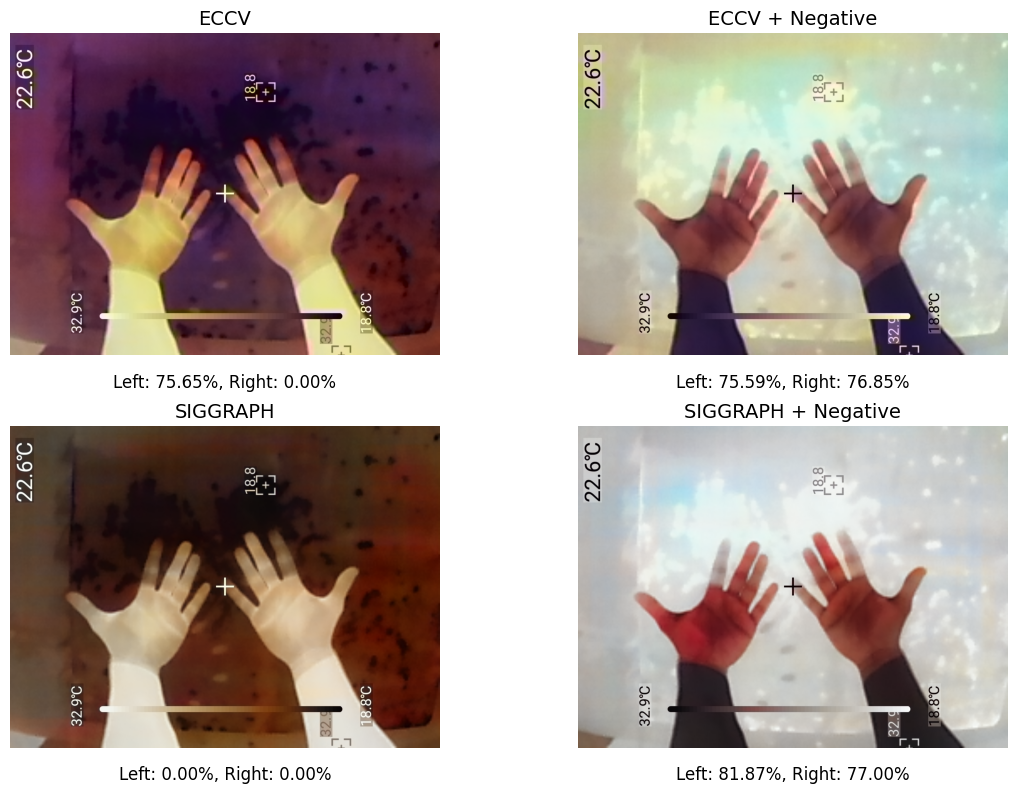

In [88]:
import cv2
import matplotlib.pyplot as plt

# Load images
eccv = cv2.cvtColor(cv2.imread('../../resources/paper/Colorized_Negative/eccv.png'), cv2.COLOR_BGR2RGB)
eccv_negative = cv2.cvtColor(cv2.imread('../../resources/paper/Colorized_Negative/eccv_negative.png'), cv2.COLOR_BGR2RGB)
siggraph = cv2.cvtColor(cv2.imread('../../resources/paper/Colorized_Negative/siggraph.png'), cv2.COLOR_BGR2RGB)
siggraph_negative = cv2.cvtColor(cv2.imread('../../resources/paper/Colorized_Negative/siggraph_negative.png'), cv2.COLOR_BGR2RGB)

# Results
results = [
    ("ECCV", eccv, "Left: 75.65%, Right: 0.00%"),
    ("ECCV + Negative", eccv_negative, "Left: 75.59%, Right: 76.85%"),
    ("SIGGRAPH", siggraph, "Left: 0.00%, Right: 0.00%"),
    ("SIGGRAPH + Negative", siggraph_negative, "Left: 81.87%, Right: 77.00%")
]

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Assign images and titles to axes
for i, ax in enumerate(axes.flat):
    title, img, score = results[i]
    ax.imshow(img)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    ax.text(0.5, -0.1, score, fontsize=12, ha='center', transform=ax.transAxes)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("comparison_figure_two_rows.png", dpi=300)
plt.show()


# Why different pipelines?

In [172]:
def first_pipeline(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(no_boxes_image_path))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [173]:
def second_pipeline(image_path, image_name):
    # no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    # # no_cross_path = remove_cross(no_boxes_image_path, image_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg", enhanced_image)
    
    # # Step 4: Sharpen edges to highlight fingers
    # kernel = np.array([[-1, -1, -1],
    #                    [-1,  9, -1],
    #                    [-1, -1, -1]])
    # sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    # 
    # # Change the image to RGB format
    sharpened_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    # 
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [174]:
def first_pipeline_with_CLAHE(image_path, image_name, colorization_model='siggraph17'):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    
    image = cv2.imread(no_boxes_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg", enhanced_image)
    
    # # Invert the colors
    inverted_image = cv2.bitwise_not(cv2.imread(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg"))
    # Save the inverted image
    inverted_image_path = f"../../resources/stylized-pictures/inverted/{image_name}_inverted.png"
    cv2.imwrite(inverted_image_path, inverted_image)
    
    

    
    # Generate colorized image using Zhang model
    transformed_image_path = None

    if colorization_model == 'eccv16':
        transformed_image_path = colorize_zhang_eccv16(inverted_image_path, image_name)
    elif colorization_model == 'siggraph17':
        transformed_image_path = colorize_zhang_siggraph17(inverted_image_path, image_name)
    
    return transformed_image_path
    

In [175]:
scores_first_pipeline = {"Left": [], "Right": []}
scores_second_pipeline = {"Left": [], "Right": []}
scores_first_pipeline_with_CLAHE = {"Left": [], "Right": []}

not_detected_or_bad = 0
hands_detected_by_first_pipeline = 0
hands_detected_by_second_pipeline = 0
hands_detected_by_third_pipeline = 0
hands_detected_by_second_no_first = 0
hands_with_better_by_second = 0

In [176]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = first_pipeline(image_path, image_name)
            first_pipeline_pck = assess_pck_accuracy(first_pipeline_image_path, ground_truth_landmarks, 0.05)
      
            
            second_pipeline_image_path = second_pipeline(image_path, image_name)
            second_pipeline_pck = assess_pck_accuracy(second_pipeline_image_path, ground_truth_landmarks, 0.05)
      
            
            
            third_pipeline_image_path = first_pipeline_with_CLAHE(image_path, image_name)
            third_pipeline_pck = assess_pck(third_pipeline_image_path, ground_truth_landmarks, 0.05)

            for hand in ["Left", "Right"]:
                scores_first_pipeline[hand].append(first_pipeline_pck[hand])
                scores_second_pipeline[hand].append(second_pipeline_pck[hand])
                scores_first_pipeline_with_CLAHE[hand].append(third_pipeline_pck[hand])
                
                if ((first_pipeline_pck[hand]) > 0.0 and  (third_pipeline_pck[hand]) == 0.0
                or ((first_pipeline_pck[hand]) - (third_pipeline_pck[hand]) > 0.10)):
                    not_detected_or_bad += 1
                    
                if (first_pipeline_pck[hand]) > 0.0:
                    hands_detected_by_first_pipeline += 1
                    
                if (second_pipeline_pck[hand]) > 0.0:
                    hands_detected_by_second_pipeline += 1
                    
                if (second_pipeline_pck[hand]) > 0.0 and (first_pipeline_pck[hand]) == 0.0:
                    hands_detected_by_second_no_first += 1
                    
                if (second_pipeline_pck[hand]) - (first_pipeline_pck[hand]) > 0.10:
                    hands_with_better_by_second += 1
                    
                if third_pipeline_pck[hand] > 0.0:
                    hands_detected_by_third_pipeline += 1
            
            
            
            print("---------------------------------------------------------")




Processing image: 1_IMG20241127100244.jpg
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 2_IMG20241127100252.jpg
Colorizing 2_IMG20241127100252.jpg using Zhang SIGGRAPH17 model...
Colorizing 2_IMG20241127100252.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 3_IMG20241127100408.jpg
Colorizing 3_IMG20241127100408.jpg using Zhang SIGGRAPH17 model...
Colorizing 3_IMG20241127100408.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 4_IMG20241127100414.jpg
Colorizing 4_IMG20241127100414.jpg using Zhang SIGGRAPH17 model...
Colorizing 4_IMG20241127100414.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 5_IMG20241127100507.jpg
Colorizing 5_IMG202411

In [177]:
# Calculate final accuracy
first_pipeline_accuracy = calculate_final_accuracy(scores_first_pipeline)
second_pipeline_accuracy = calculate_final_accuracy(scores_second_pipeline)
first_pipeline_with_CLAHE_accuracy = calculate_final_accuracy(scores_first_pipeline_with_CLAHE)

In [178]:
print(f"First Pipeline Accuracy: {first_pipeline_accuracy:.2f}%")
print(f"Second Pipeline Accuracy: {second_pipeline_accuracy:.2f}%")
print(f"First Pipeline with CLAHE Accuracy: {first_pipeline_with_CLAHE_accuracy:.2f}%")

First Pipeline Accuracy: 0.60%
Second Pipeline Accuracy: 0.42%
First Pipeline with CLAHE Accuracy: 0.52%


In [179]:
print(f"Number of images not detected or bad: {not_detected_or_bad}")
print(f"Number of hands detected by first pipeline: {hands_detected_by_first_pipeline}")
print(f"Number of hands detected by second pipeline: {hands_detected_by_second_pipeline}")
print(f"Number of hands detected by second pipeline but not by first: {hands_detected_by_second_no_first}")
print(f"Number of hands with better detection by second pipeline: {hands_with_better_by_second}")
print(f"Number of hands detected by third pipeline: {hands_detected_by_third_pipeline}")


Number of images not detected or bad: 25
Number of hands detected by first pipeline: 143
Number of hands detected by second pipeline: 92
Number of hands detected by second pipeline but not by first: 4
Number of hands with better detection by second pipeline: 0
Number of hands detected by third pipeline: 122


In [181]:
thresholds = [0.025, 0.05, 0.07]
hands_detected_by_pipeline = {threshold: {"First": 0, "Second": 0, "Third": 0} for threshold in thresholds}
hands_with_better_by_second = {threshold: 0 for threshold in thresholds}

# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = first_pipeline(image_path, image_name)
            second_pipeline_image_path = second_pipeline(image_path, image_name)
            

            for threshold in thresholds:
                first_pipeline_pck = assess_pck_accuracy(first_pipeline_image_path, ground_truth_landmarks, threshold)
                second_pipeline_pck = assess_pck_accuracy(second_pipeline_image_path, ground_truth_landmarks, threshold)

                for hand in ["Left", "Right"]:
                    if first_pipeline_pck[hand] > 0.0:
                        hands_detected_by_pipeline[threshold]["First"] += 1
                    if second_pipeline_pck[hand] > 0.0:
                        hands_detected_by_pipeline[threshold]["Second"] += 1
                    
                    if (second_pipeline_pck[hand] - first_pipeline_pck[hand]) > 0.10:
                        hands_with_better_by_second[threshold] += 1
                        
            third_pipeline_image_path = first_pipeline_with_CLAHE(image_path, image_name)
            
            for threshold in thresholds:
            
                third_pipeline_pck = assess_pck(third_pipeline_image_path, ground_truth_landmarks, threshold)

                for hand in ["Left", "Right"]:
                    if third_pipeline_pck[hand] > 0.0:
                        hands_detected_by_pipeline[threshold]["Third"] += 1
                    
            
            print("---------------------------------------------------------")

# Print results
print("Hands Detected by Pipeline:")
print(hands_detected_by_pipeline)
print("Hands Improved by Second Pipeline:")
print(hands_with_better_by_second)


Processing image: 1_IMG20241127100244.jpg
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 2_IMG20241127100252.jpg
Colorizing 2_IMG20241127100252.jpg using Zhang SIGGRAPH17 model...
Colorizing 2_IMG20241127100252.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 3_IMG20241127100408.jpg
Colorizing 3_IMG20241127100408.jpg using Zhang SIGGRAPH17 model...
Colorizing 3_IMG20241127100408.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 4_IMG20241127100414.jpg
Colorizing 4_IMG20241127100414.jpg using Zhang SIGGRAPH17 model...
Colorizing 4_IMG20241127100414.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 5_IMG20241127100507.jpg
Colorizing 5_IMG202411

In [59]:
def second_pipeline_sharpening(image_path, image_name):
    # no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    # # no_cross_path = remove_cross(no_boxes_image_path, image_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg", enhanced_image)
    
    # Step 4: Sharpen edges to highlight fingers
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)

    # # Change the image to RGB format
    sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)
    # 
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [65]:
def second_pipeline_sharpening_and_removal(image_path, image_name):
    no_boxes_image_path = remove_temperature_boxes(image_path, image_name)
    # # no_cross_path = remove_cross(no_boxes_image_path, image_name)
    
    image = cv2.imread(no_boxes_image_path, cv2.IMREAD_GRAYSCALE)
    
    
    # Step 3: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    cv2.imwrite(f"../../resources/stylized-pictures/clahe/{image_name}_clahe.jpg", enhanced_image)
    
    # Step 4: Sharpen edges to highlight fingers
    # kernel = np.array([[-1, -1, -1],
    #                    [-1,  9, -1],
    #                    [-1, -1, -1]])
    # sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)
    # 
    # # # Change the image to RGB format
    sharpened_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    # # 
    sharpened_image_path = f"../../resources/stylized-pictures/not_detected/sharpened/{image_name}_sharpened.png"
    cv2.imwrite(sharpened_image_path, sharpened_image)
    
    # transformed_image_path = colorize_zhang_siggraph17(sharpened_image_path, image_name)
    
    return sharpened_image_path
    

In [66]:
second_sharpening = {"Left": [], "Right": []}
second_sharpening_and_removal = {"Left": [], "Right": []}

In [67]:
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = second_pipeline_sharpening(image_path, image_name)
            first_pipeline_score = assess_accuracy(first_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for original pipeline - Left: {np.mean(first_pipeline_score['Left']):.2f}%, Right: {np.mean(first_pipeline_score['Right']):.2f}%")
            
            second_pipeline_image_path = second_pipeline_sharpening_and_removal(image_path, image_name)
            second_pipeline_score = assess_accuracy(second_pipeline_image_path, ground_truth_landmarks)
            print(f"Results for second pipeline - Left: {np.mean(second_pipeline_score['Left']):.2f}%, Right: {np.mean(second_pipeline_score['Right']):.2f}%")
            
            
            # third_pipeline_image_path = first_pipeline_with_CLAHE(image_path, image_name)
            # third_pipeline_score = assess_accuracy(third_pipeline_image_path, ground_truth_landmarks)
            # print(f"Results for third pipeline - Left: {np.mean(third_pipeline_score['Left']):.2f}%, Right: {np.mean(third_pipeline_score['Right']):.2f}%")
            
            for hand in ["Left", "Right"]:
                second_sharpening[hand].extend(first_pipeline_score[hand])
                second_sharpening_and_removal[hand].extend(second_pipeline_score[hand])
                
               
            
            
            
            print("---------------------------------------------------------")




Processing image: 1_IMG20241127100244.jpg
Results for original pipeline - Left: 59.21%, Right: 78.33%
Results for second pipeline - Left: 67.74%, Right: 74.71%
---------------------------------------------------------
Processing image: 2_IMG20241127100252.jpg
Results for original pipeline - Left: 65.40%, Right: 78.24%
Results for second pipeline - Left: 65.88%, Right: 72.97%
---------------------------------------------------------
Processing image: 3_IMG20241127100408.jpg
Results for original pipeline - Left: 75.68%, Right: 0.00%
Results for second pipeline - Left: 77.17%, Right: 67.95%
---------------------------------------------------------
Processing image: 4_IMG20241127100414.jpg
No hands detected for ../../resources/stylized-pictures/not_detected/sharpened/4_IMG20241127100414.jpg_sharpened.png
Results for original pipeline - Left: 0.00%, Right: 0.00%
Results for second pipeline - Left: 73.63%, Right: 71.17%
---------------------------------------------------------
Processing ima

In [68]:
# Calculate final accuracy
second_sharpening_accuracy = calculate_final_accuracy(second_sharpening)
second_sharpening_and_removal_accuracy = calculate_final_accuracy(second_sharpening_and_removal)

In [69]:
print(f"Second Sharpening Accuracy: {second_sharpening_accuracy:.2f}%")
print(f"Second Sharpening and Removal Accuracy: {second_sharpening_and_removal_accuracy:.2f}%")

Second Sharpening Accuracy: 31.88%
Second Sharpening and Removal Accuracy: 41.68%


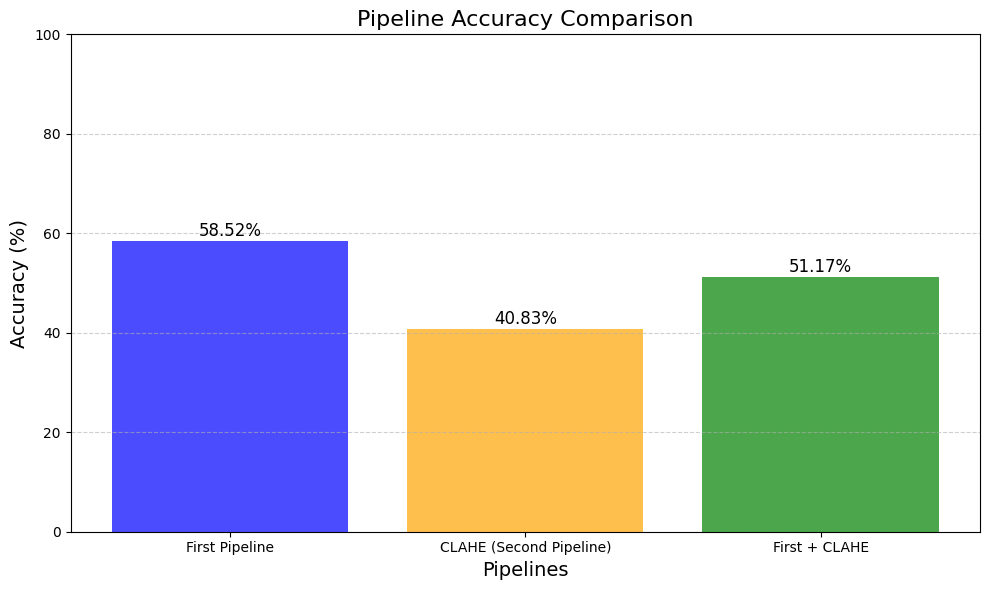

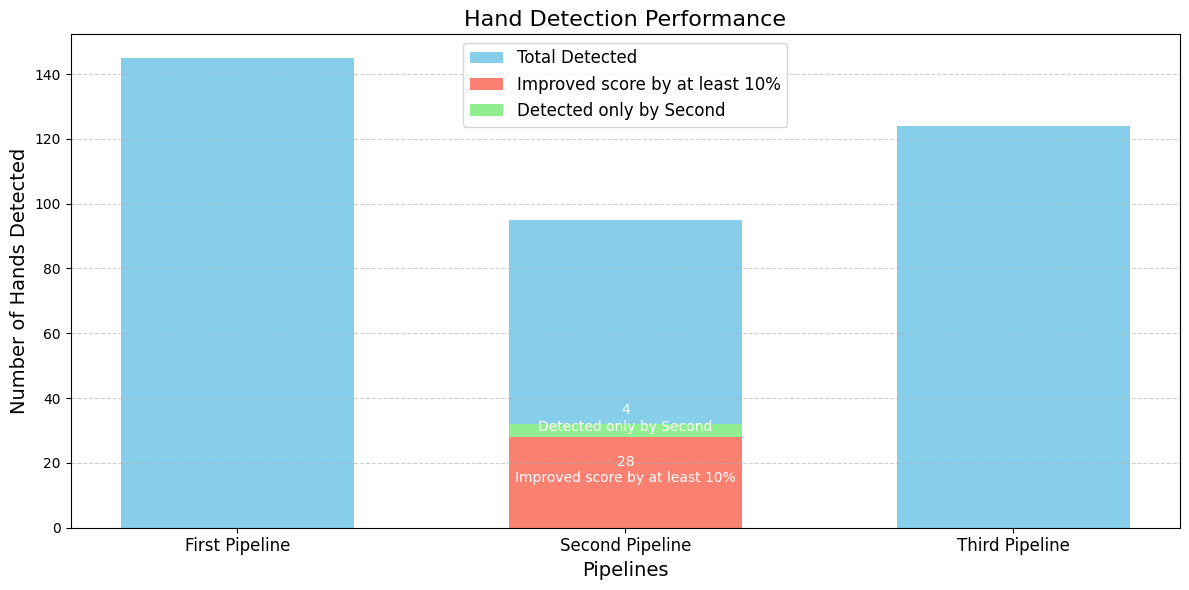

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the charts
pipelines = ["First Pipeline", "CLAHE (Second Pipeline)", "First + CLAHE"]
accuracy = [58.52, 40.83, 51.17]

# Detection data
detection_pipelines = ["First Pipeline", "Second Pipeline", "Third Pipeline"]
hands_detected = [145, 95, 124]
special_cases = [
    ("Improved score by at least 10%", 28),
    ("Detected only by Second", 4)
]

# Create Accuracy Comparison Chart
plt.figure(figsize=(10, 6))
plt.bar(pipelines, accuracy, color=['blue', 'orange', 'green'], alpha=0.7)
plt.title("Pipeline Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xlabel("Pipelines", fontsize=14)
plt.ylim(0, 100)
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 1, f"{acc}%", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Create Detection Analysis Chart
x = np.arange(len(detection_pipelines))  # X-axis positions
bar_width = 0.6

plt.figure(figsize=(12, 6))

# First bar for total hands detected
plt.bar(x, hands_detected, width=bar_width, color='skyblue', label="Total Detected")

# Overlay for special cases with three colors in the middle bar
second_pipeline_base = hands_detected[1]
plt.bar(x[1], special_cases[0][1], width=bar_width, color='salmon', label="Improved score by at least 10%")
plt.bar(x[1], special_cases[1][1], width=bar_width, bottom=special_cases[0][1], color='lightgreen', label="Detected only by Second")

# Annotate special cases
plt.text(x[1], special_cases[0][1] / 2, f"{special_cases[0][1]}\n{special_cases[0][0]}", ha='center', fontsize=10, color='white')
plt.text(x[1], special_cases[0][1] + special_cases[1][1] / 2, f"{special_cases[1][1]}\n{special_cases[1][0]}", ha='center', fontsize=10, color='white')

plt.title("Hand Detection Performance", fontsize=16)
plt.ylabel("Number of Hands Detected", fontsize=14)
plt.xlabel("Pipelines", fontsize=14)
plt.xticks(x, detection_pipelines, fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


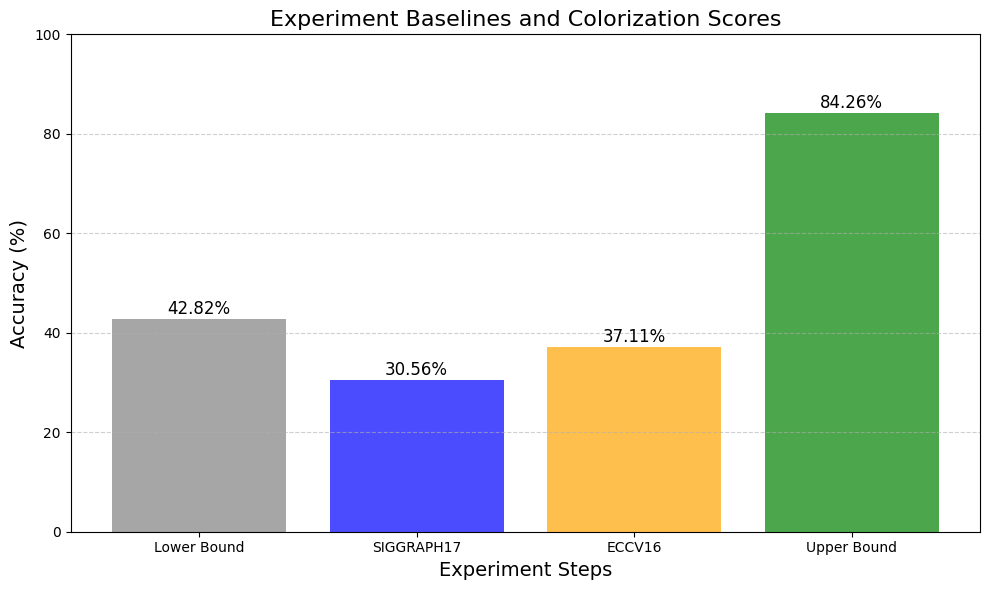

In [4]:
# SIGGRAPH and ECCV Scores with Bounds
experiment_steps = ["Lower Bound", "SIGGRAPH17", "ECCV16", "Upper Bound"]
scores = [42.82, 30.56, 37.11, 84.26]


# Create SIGGRAPH and ECCV Scores Chart
plt.figure(figsize=(10, 6))
plt.bar(experiment_steps, scores, color=['gray', 'blue', 'orange', 'green'], alpha=0.7)
plt.title("Experiment Baselines and Colorization Scores", fontsize=16)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.xlabel("Experiment Steps", fontsize=14)
plt.ylim(0, 100)
for i, score in enumerate(scores):
    plt.text(i, score + 1, f"{score}%", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Checking main visual

In [161]:
thresholds = [0.025, 0.05, 0.07]

overall_first_pipeline = {t: {"Left": [], "Right": []} for t in thresholds}
overall_second_pipeline = {t: {"Left": [], "Right": []} for t in thresholds}
overall_results = {t: {"Left": [], "Right": []} for t in thresholds}

In [162]:
import cv2
# Process each image
for file_name in os.listdir(IR_ground_truth_directory):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(IR_ground_truth_directory, file_name)
        
        with open(json_file_path, 'r') as f:
            ground_truth_data = json.load(f)
            
        for entry in ground_truth_data:
            
            image_name = entry["image"]
            ground_truth_landmarks = entry["landmarks"]
            ground_truth_landmarks = rotate_landmarks_90_counterclockwise(ground_truth_landmarks)
            image_path = f"{IR_image_directory}/{image_name}"
            
            image = cv2.imread(image_path)
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            rotated_path = f"../../resources/stylized-pictures/rotated/{image_name}_rotated.png"
            cv2.imwrite(rotated_path, rotated)
            image_path = rotated_path
            
            
            print(f"Processing image: {image_name}")

            first_pipeline_image_path = execute_transformation_pipeline(image_path, image_name)
            # first_pipeline_pck = assess_pck_accuracy(first_pipeline_image_path, ground_truth_landmarks, 0.05)
            # print(f"Results for original pipeline (PCK) - Left: {first_pipeline_pck['Left'] * 100:.2f}%, Right: {first_pipeline_pck['Right'] * 100:.2f}%")
            # 
            second_pipeline_image_path = execute_transformation_pipeline_with_no_visible_fingers(image_path, image_name)
            # second_pipeline_pck = assess_pck_accuracy(second_pipeline_image_path, ground_truth_landmarks, 0.05)
            # print(f"Results for second pipeline (PCK) - Left: {second_pipeline_pck['Left'] * 100:.2f}%, Right: {second_pipeline_pck['Right'] * 100:.2f}%")
            # 

            image = mp.Image.create_from_file(first_pipeline_image_path)
            recognizer_results_first_pipeline = gesture_recognizer.recognize(image)
            first_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_first_pipeline)
            annotated_first = draw_landmarks_on_image(cv2.imread(first_pipeline_image_path), recognizer_results_first_pipeline)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/first/{image_name}.png", annotated_first)
            
            image = mp.Image.create_from_file(second_pipeline_image_path)
            recognizer_results_second_pipeline = gesture_recognizer.recognize(image)
            second_pipeline_gesture_score_landmarks = create_landmarks_from_results(recognizer_results_second_pipeline)
            annotated_second = draw_landmarks_on_image(cv2.imread(second_pipeline_image_path), recognizer_results_second_pipeline)
            cv2.imwrite(f"../../resources/stylized-pictures/annotated/second/{image_name}.png", annotated_second)

            # Initialize landmarks_gestures_score dictionary
            landmarks_gestures_score = {"Left": [], "Right": []}
            
            # Check if landmarks exist for each pipeline and append them accordingly
            if "Left" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(first_pipeline_gesture_score_landmarks["Left"])
            if "Right" in first_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(first_pipeline_gesture_score_landmarks["Right"])
            
            if "Left" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Left"].append(second_pipeline_gesture_score_landmarks["Left"])
            if "Right" in second_pipeline_gesture_score_landmarks:
                landmarks_gestures_score["Right"].append(second_pipeline_gesture_score_landmarks["Right"])

            final_landmarks = []
            
            for hand in ["Left", "Right"]:
                all_available_landmarks = landmarks_gestures_score[hand]
                
                if not all_available_landmarks:
                    continue
            
                # Step 1: Filter only open palm gestures
                open_palm_landmarks = [l for l in all_available_landmarks if l['gestures'] == 'Open_Palm']
            
                # Step 2: Handle multiple open palms
                if len(open_palm_landmarks) > 1:
                    merged_landmarks = merge_landmarks(open_palm_landmarks, hand)
                    final_landmarks.append(merged_landmarks)
            
                # Step 3: Handle a single open palm
                elif len(open_palm_landmarks) == 1:
                    final_landmarks.append(open_palm_landmarks[0]['landmarks'])
            
                # Step 4: No open palm detected, use lowest score gesture
                else:
                    lowest_score_landmark = min(all_available_landmarks, key=lambda l: l['score'])
                    final_landmarks.append(lowest_score_landmark['landmarks'])

            # 
            # final_pck = calculate_best_pck_adaptive(ground_truth_landmarks, final_landmarks, 0.05)
            # print(f"Results for final score (PCK) - Left: {final_pck['Left'] * 100:.2f}%, Right: {final_pck['Right'] * 100:.2f}%")
            # 
            for t in thresholds:
                first_pipeline_pck = assess_pck_accuracy(first_pipeline_image_path, ground_truth_landmarks, t)
                second_pipeline_pck = assess_pck_accuracy(second_pipeline_image_path, ground_truth_landmarks, t)
                final_pck = calculate_best_pck_adaptive(ground_truth_landmarks, final_landmarks, t)
                
                for hand in ["Left", "Right"]:
                    overall_first_pipeline[t][hand].append(first_pipeline_pck[hand])
                    overall_second_pipeline[t][hand].append(second_pipeline_pck[hand])
                    overall_results[t][hand].append(final_pck[hand])


            print("---------------------------------------------------------")
# or image_name != '54_IMG20241127103409.jpg' or image_name != '56_IMG20241127103449.jpg' 6_IMG20241127100515


Processing image: 1_IMG20241127100244.jpg
Colorizing 1_IMG20241127100244.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 2_IMG20241127100252.jpg
Colorizing 2_IMG20241127100252.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 3_IMG20241127100408.jpg
Colorizing 3_IMG20241127100408.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 4_IMG20241127100414.jpg
Colorizing 4_IMG20241127100414.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 5_IMG20241127100507.jpg
Colorizing 5_IMG20241127100507.jpg using Zhang SIGGRAPH17 model...
---------------------------------------------------------
Processing image: 6_IMG20241127100515.jpg
Colorizing 6_IMG20241127100515.jpg using Zhang SIGGRAPH17 model...
--------------------------------------------------------

In [163]:
# Calculate final accuracy
first_pipeline_accuracy = {t: calculate_final_accuracy(overall_first_pipeline[t]) for t in thresholds}
second_pipeline_accuracy = {t: calculate_final_accuracy(overall_second_pipeline[t]) for t in thresholds}
final_accuracy = {t: calculate_final_accuracy(overall_results[t]) for t in thresholds}

In [165]:
print("First Pipeline Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {first_pipeline_accuracy[t] * 100:.2f}%")
    
print("Second Pipeline Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {second_pipeline_accuracy[t] * 100:.2f}%")
    
print("Final Accuracy")
for t in thresholds:
    print(f"Threshold: {t}, Accuracy: {final_accuracy[t] * 100:.2f}%")

First Pipeline Accuracy
Threshold: 0.025, Accuracy: 31.46%
Threshold: 0.05, Accuracy: 60.21%
Threshold: 0.07, Accuracy: 70.21%
Second Pipeline Accuracy
Threshold: 0.025, Accuracy: 23.51%
Threshold: 0.05, Accuracy: 43.45%
Threshold: 0.07, Accuracy: 49.73%
Final Accuracy
Threshold: 0.025, Accuracy: 35.89%
Threshold: 0.05, Accuracy: 66.55%
Threshold: 0.07, Accuracy: 76.76%
